In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import RepeatedStratifiedKFold
#from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.ensemble import RandomForestClassifier

import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import log_loss

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns

In [3]:
df = pd.read_csv('spam.csv',encoding='latin-1')

In [4]:
df

v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN  
1           NaN        NaN  
2           NaN        NaN  
3           NaN        NaN  
4           NaN        NaN  
...         ...        ...  
5567        NaN        NaN  
5568        NaN        NaN  
5569        NaN        NaN  
5570        NaN        NaN  
5571        NaN        NaN  

[5572 rows x 5 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
df = df.rename(columns={"v1": "Spam", "v2": "SMS"})

In [7]:
df = df.dropna(axis='columns')

In [8]:
Spam_count = df.Spam.value_counts()
Spam_count

ham     4825
spam     747
Name: Spam, dtype: int64

In [9]:
# print Spam percentage
print(f'Spam: {Spam_count[1]}')
print(f'No Spam: {Spam_count[0]}')
print(f'Percentage of Spam: {round(Spam_count[1] / sum(Spam_count),3) *100} %')

Spam: 747
No Spam: 4825
Percentage of Spam: 13.4 %


In [10]:
df['Spam'],_ = pd.factorize(df['Spam'])
df.head(3)

Spam                                                SMS
0     0  Go until jurong point, crazy.. Available only ...
1     0                      Ok lar... Joking wif u oni...
2     1  Free entry in 2 a wkly comp to win FA Cup fina...

In [11]:
df['SMS_len'] = df.SMS.apply(len)
df.head()

Spam                                                SMS  SMS_len
0     0  Go until jurong point, crazy.. Available only ...      111
1     0                      Ok lar... Joking wif u oni...       29
2     1  Free entry in 2 a wkly comp to win FA Cup fina...      155
3     0  U dun say so early hor... U c already then say...       49
4     0  Nah I don't think he goes to usf, he lives aro...       61

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Spam     5572 non-null   int64 
 1   SMS      5572 non-null   object
 2   SMS_len  5572 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 130.7+ KB


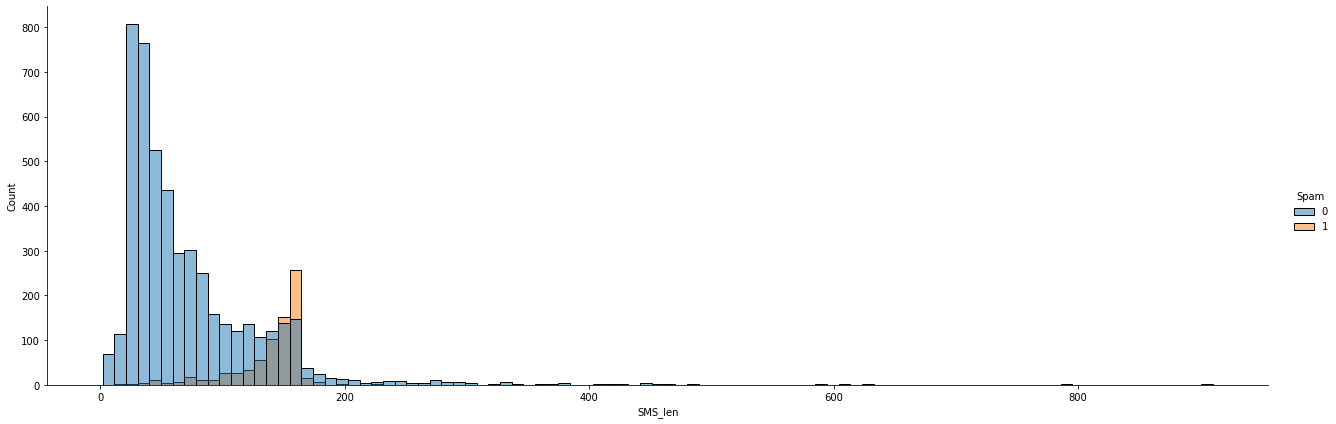

In [13]:
sns.displot(df, x="SMS_len", hue="Spam", kind="hist",height=6, aspect=3)


From above, spam messages tend to have more characters.

In [14]:
df[df.Spam==1].describe()

Spam     SMS_len
count  747.0  747.000000
mean     1.0  138.866131
std      0.0   29.183082
min      1.0   13.000000
25%      1.0  132.500000
50%      1.0  149.000000
75%      1.0  157.000000
max      1.0  224.000000

In [15]:
df[df.Spam==0].describe()

Spam      SMS_len
count  4825.0  4825.000000
mean      0.0    71.023627
std       0.0    58.016023
min       0.0     2.000000
25%       0.0    33.000000
50%       0.0    52.000000
75%       0.0    92.000000
max       0.0   910.000000

In [16]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import regex as re  
import string
from collections import Counter

from nltk.corpus import stopwords
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\syleo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\syleo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
#remove punctuations except ! and $

txt = ")*^%{}[]thi's - is$ - @@#!a !%%!!%$- test."

#re.sub(pattern, "", txt) 
txt = re.sub("[^\P{P}$!]+", "", txt)
                        
print(txt)

^this  is$  !a !!!$ test


In [18]:
#remove punctuations except ! and $
txt = ")*^%{}[]thi's - is$ - @@#!a !%%!!%$- test."

remove = string.punctuation
remove = remove.replace("$", "") # don't remove ! and $
remove = remove.replace("!", "")
pattern = r"[{}]".format(remove)
txt = re.sub(pattern, "", txt) 

print(txt)

this  is$  !a !!!$ test


In [19]:
def text_process(text):  
    # carry out tokenization first, 
    #then lower case, 
    #then remove punctuation except !
    #remove stopwords
    #remove words that contain numbers

    
    # split into sentences
    #sentences = sent_tokenize(text)
    #print(sentences)
    
    # split into words
    tokens = word_tokenize(text)
    print(tokens)
        
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    print(tokens)
          
    #remove punctuations from each word except !
    remove = string.punctuation
    remove = remove.replace("!", "")    
    table = str.maketrans('', '', remove)
    stripped = [w.translate(table) for w in tokens]
    print(stripped)

    # filter out stop words
    STOPWORDS = stopwords.words('english') + ['ur', 'im', 'dont', 'doin', 'ure', 'wif', 'oni','la','wat', 'cine','amore', '', 'e', 'v', 'wat', 'oni', 'k', 'u', 'r', '2', '4', 'x', 'b', 'c']    
    words = [w for w in stripped if not w in STOPWORDS]
    print(words)        
    
    #filter out words that contains numbers
    words1 = [w for w in words if not any(c.isdigit() for c in w)]
    print(words1)
    
    return ' '.join(w for w in words1)
    

In [20]:
df['clean_msg'] = df.SMS.apply(text_process)

['Go', 'until', 'jurong', 'point', ',', 'crazy', '..', 'Available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', '...', 'Cine', 'there', 'got', 'amore', 'wat', '...']
['go', 'until', 'jurong', 'point', ',', 'crazy', '..', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', '...', 'cine', 'there', 'got', 'amore', 'wat', '...']
['go', 'until', 'jurong', 'point', '', 'crazy', '', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', '', 'cine', 'there', 'got', 'amore', 'wat', '']
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'buffet', 'got']
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'buffet', 'got']
['Ok', 'lar', '...', 'Joking', 'wif', 'u', 'oni', '...']
['ok', 'lar', '...', 'joking', 'wif', 'u', 'oni', '...']
['ok', 'lar', '', 'joking', 'wif', 'u', 'oni', '']
['ok', 'lar', 'joking']
['ok', 'lar', 'joking']
['Free', 'entry', 'in', '2', 'a', '

['customer', 'service', 'annoncement', 'new', 'years', 'delivery', 'waiting', 'please', 'call', '07046744435', 'arrange', 'delivery']
['customer', 'service', 'annoncement', 'new', 'years', 'delivery', 'waiting', 'please', 'call', 'arrange', 'delivery']
['You', 'are', 'a', 'winner', 'U', 'have', 'been', 'specially', 'selected', '2', 'receive', 'å£1000', 'cash', 'or', 'a', '4', '*', 'holiday', '(', 'flights', 'inc', ')', 'speak', 'to', 'a', 'live', 'operator', '2', 'claim', '0871277810810']
['you', 'are', 'a', 'winner', 'u', 'have', 'been', 'specially', 'selected', '2', 'receive', 'å£1000', 'cash', 'or', 'a', '4', '*', 'holiday', '(', 'flights', 'inc', ')', 'speak', 'to', 'a', 'live', 'operator', '2', 'claim', '0871277810810']
['you', 'are', 'a', 'winner', 'u', 'have', 'been', 'specially', 'selected', '2', 'receive', 'å£1000', 'cash', 'or', 'a', '4', '', 'holiday', '', 'flights', 'inc', '', 'speak', 'to', 'a', 'live', 'operator', '2', 'claim', '0871277810810']
['winner', 'specially', 'se

['call', 'germany', '1', 'pence', 'per', 'minute', '!', 'call', 'fixed', 'line', 'via', 'access', 'number', '0844', '861', '85', '85', 'prepayment', 'direct', 'access', '!']
['call', 'germany', 'pence', 'per', 'minute', '!', 'call', 'fixed', 'line', 'via', 'access', 'number', 'prepayment', 'direct', 'access', '!']
['Any', 'chance', 'you', 'might', 'have', 'had', 'with', 'me', 'evaporated', 'as', 'soon', 'as', 'you', 'violated', 'my', 'privacy', 'by', 'stealing', 'my', 'phone', 'number', 'from', 'your', 'employer', "'s", 'paperwork', '.', 'Not', 'cool', 'at', 'all', '.', 'Please', 'do', 'not', 'contact', 'me', 'again', 'or', 'I', 'will', 'report', 'you', 'to', 'your', 'supervisor', '.']
['any', 'chance', 'you', 'might', 'have', 'had', 'with', 'me', 'evaporated', 'as', 'soon', 'as', 'you', 'violated', 'my', 'privacy', 'by', 'stealing', 'my', 'phone', 'number', 'from', 'your', 'employer', "'s", 'paperwork', '.', 'not', 'cool', 'at', 'all', '.', 'please', 'do', 'not', 'contact', 'me', 'aga

['jst', 'change', 'tat']
['jst', 'change', 'tat']
['You', 'are', 'guaranteed', 'the', 'latest', 'Nokia', 'Phone', ',', 'a', '40GB', 'iPod', 'MP3', 'player', 'or', 'a', 'å£500', 'prize', '!', 'Txt', 'word', ':', 'COLLECT', 'to', 'No', ':', '83355', '!', 'IBHltd', 'LdnW15H', '150p/Mtmsgrcvd18+']
['you', 'are', 'guaranteed', 'the', 'latest', 'nokia', 'phone', ',', 'a', '40gb', 'ipod', 'mp3', 'player', 'or', 'a', 'å£500', 'prize', '!', 'txt', 'word', ':', 'collect', 'to', 'no', ':', '83355', '!', 'ibhltd', 'ldnw15h', '150p/mtmsgrcvd18+']
['you', 'are', 'guaranteed', 'the', 'latest', 'nokia', 'phone', '', 'a', '40gb', 'ipod', 'mp3', 'player', 'or', 'a', 'å£500', 'prize', '!', 'txt', 'word', '', 'collect', 'to', 'no', '', '83355', '!', 'ibhltd', 'ldnw15h', '150pmtmsgrcvd18']
['guaranteed', 'latest', 'nokia', 'phone', '40gb', 'ipod', 'mp3', 'player', 'å£500', 'prize', '!', 'txt', 'word', 'collect', '83355', '!', 'ibhltd', 'ldnw15h', '150pmtmsgrcvd18']
['guaranteed', 'latest', 'nokia', 'phone'

['my', 'sister', 'in', 'law', '', 'hope', 'you', 'are', 'having', 'a', 'great', 'month', '', 'just', 'saying', 'hey', '', 'abiola']
['sister', 'law', 'hope', 'great', 'month', 'saying', 'hey', 'abiola']
['sister', 'law', 'hope', 'great', 'month', 'saying', 'hey', 'abiola']
['Will', 'purchase', 'd', 'stuff', 'today', 'and', 'mail', 'to', 'you', '.', 'Do', 'you', 'have', 'a', 'po', 'box', 'number', '?']
['will', 'purchase', 'd', 'stuff', 'today', 'and', 'mail', 'to', 'you', '.', 'do', 'you', 'have', 'a', 'po', 'box', 'number', '?']
['will', 'purchase', 'd', 'stuff', 'today', 'and', 'mail', 'to', 'you', '', 'do', 'you', 'have', 'a', 'po', 'box', 'number', '']
['purchase', 'stuff', 'today', 'mail', 'po', 'box', 'number']
['purchase', 'stuff', 'today', 'mail', 'po', 'box', 'number']
['Ah', 'poop', '.', 'Looks', 'like', 'ill', 'prob', 'have', 'to', 'send', 'in', 'my', 'laptop', 'to', 'get', 'fixed', 'cuz', 'it', 'has', 'a', 'gpu', 'problem']
['ah', 'poop', '.', 'looks', 'like', 'ill', 'prob'

['find', 'time', 'bus', 'coz', 'need', 'sort', 'stuff']
['Dude', 'ive', 'been', 'seeing', 'a', 'lotta', 'corvettes', 'lately']
['dude', 'ive', 'been', 'seeing', 'a', 'lotta', 'corvettes', 'lately']
['dude', 'ive', 'been', 'seeing', 'a', 'lotta', 'corvettes', 'lately']
['dude', 'ive', 'seeing', 'lotta', 'corvettes', 'lately']
['dude', 'ive', 'seeing', 'lotta', 'corvettes', 'lately']
['Congratulations', 'ur', 'awarded', 'either', 'a', 'yrs', 'supply', 'of', 'CDs', 'from', 'Virgin', 'Records', 'or', 'a', 'Mystery', 'Gift', 'GUARANTEED', 'Call', '09061104283', 'Ts', '&', 'Cs', 'www.smsco.net', 'å£1.50pm', 'approx', '3mins']
['congratulations', 'ur', 'awarded', 'either', 'a', 'yrs', 'supply', 'of', 'cds', 'from', 'virgin', 'records', 'or', 'a', 'mystery', 'gift', 'guaranteed', 'call', '09061104283', 'ts', '&', 'cs', 'www.smsco.net', 'å£1.50pm', 'approx', '3mins']
['congratulations', 'ur', 'awarded', 'either', 'a', 'yrs', 'supply', 'of', 'cds', 'from', 'virgin', 'records', 'or', 'a', 'myster

['mmm', 'thats', 'better', 'got', 'roast', '!', 'iåõd', 'better', 'drinks', '!', 'good', 'indian']
['mmm', 'thats', 'better', 'got', 'roast', '!', 'iåõd', 'better', 'drinks', '!', 'good', 'indian']
['We', 'know', 'someone', 'who', 'you', 'know', 'that', 'fancies', 'you', '.', 'Call', '09058097218', 'to', 'find', 'out', 'who', '.', 'POBox', '6', ',', 'LS15HB', '150p']
['we', 'know', 'someone', 'who', 'you', 'know', 'that', 'fancies', 'you', '.', 'call', '09058097218', 'to', 'find', 'out', 'who', '.', 'pobox', '6', ',', 'ls15hb', '150p']
['we', 'know', 'someone', 'who', 'you', 'know', 'that', 'fancies', 'you', '', 'call', '09058097218', 'to', 'find', 'out', 'who', '', 'pobox', '6', '', 'ls15hb', '150p']
['know', 'someone', 'know', 'fancies', 'call', '09058097218', 'find', 'pobox', '6', 'ls15hb', '150p']
['know', 'someone', 'know', 'fancies', 'call', 'find', 'pobox']
['Come', 'round', ',', 'it', "'s", '.']
['come', 'round', ',', 'it', "'s", '.']
['come', 'round', '', 'it', 's', '']
['come

['No', '.', '1', 'Nokia', 'Tone', '4', 'ur', 'mob', 'every', 'week', '!', 'Just', 'txt', 'NOK', 'to', '87021', '.', '1st', 'Tone', 'FREE', '!', 'so', 'get', 'txtin', 'now', 'and', 'tell', 'ur', 'friends', '.', '150p/tone', '.', '16', 'reply', 'HL', '4info']
['no', '.', '1', 'nokia', 'tone', '4', 'ur', 'mob', 'every', 'week', '!', 'just', 'txt', 'nok', 'to', '87021', '.', '1st', 'tone', 'free', '!', 'so', 'get', 'txtin', 'now', 'and', 'tell', 'ur', 'friends', '.', '150p/tone', '.', '16', 'reply', 'hl', '4info']
['no', '', '1', 'nokia', 'tone', '4', 'ur', 'mob', 'every', 'week', '!', 'just', 'txt', 'nok', 'to', '87021', '', '1st', 'tone', 'free', '!', 'so', 'get', 'txtin', 'now', 'and', 'tell', 'ur', 'friends', '', '150ptone', '', '16', 'reply', 'hl', '4info']
['1', 'nokia', 'tone', 'mob', 'every', 'week', '!', 'txt', 'nok', '87021', '1st', 'tone', 'free', '!', 'get', 'txtin', 'tell', 'friends', '150ptone', '16', 'reply', 'hl', '4info']
['nokia', 'tone', 'mob', 'every', 'week', '!', 'txt

['kaiez', 'enjoy', 'tuition', 'gee', 'thk', 'second', 'option', 'sounds', 'beta', 'go', 'yan', 'jiu', 'den', 'msg']
['kaiez', 'enjoy', 'tuition', 'gee', 'thk', 'second', 'option', 'sounds', 'beta', 'go', 'yan', 'jiu', 'den', 'msg']
['You', 'have', 'registered', 'Sinco', 'as', 'Payee', '.', 'Log', 'in', 'at', 'icicibank.com', 'and', 'enter', 'URN', '&', 'lt', ';', '#', '&', 'gt', ';', 'to', 'confirm', '.', 'Beware', 'of', 'frauds', '.', 'Do', 'NOT', 'share', 'or', 'disclose', 'URN', 'to', 'anyone', '.']
['you', 'have', 'registered', 'sinco', 'as', 'payee', '.', 'log', 'in', 'at', 'icicibank.com', 'and', 'enter', 'urn', '&', 'lt', ';', '#', '&', 'gt', ';', 'to', 'confirm', '.', 'beware', 'of', 'frauds', '.', 'do', 'not', 'share', 'or', 'disclose', 'urn', 'to', 'anyone', '.']
['you', 'have', 'registered', 'sinco', 'as', 'payee', '', 'log', 'in', 'at', 'icicibankcom', 'and', 'enter', 'urn', '', 'lt', '', '', '', 'gt', '', 'to', 'confirm', '', 'beware', 'of', 'frauds', '', 'do', 'not', 'sha

['How', 'to', 'Make', 'a', 'girl', 'Happy', '?', 'It', "'s", 'not', 'at', 'all', 'difficult', 'to', 'make', 'girls', 'happy', '.', 'U', 'only', 'need', 'to', 'be', '...', '1', '.', 'A', 'friend', '2', '.', 'Companion', '3', '.', 'Lover', '4', '.', 'Chef', '.', '.', '.', '&', 'lt', ';', '#', '&', 'gt', ';', '.', 'Good', 'listener', '&', 'lt', ';', '#', '&', 'gt', ';', '.', 'Organizer', '&', 'lt', ';', '#', '&', 'gt', ';', '.', 'Good', 'boyfriend', '&', 'lt', ';', '#', '&', 'gt', ';', '.', 'Very', 'clean', '&', 'lt', ';', '#', '&', 'gt', ';', '.', 'Sympathetic', '&', 'lt', ';', '#', '&', 'gt', ';', '.', 'Athletic', '&', 'lt', ';', '#', '&', 'gt', ';', '.', 'Warm', '.', '.', '.', '&', 'lt', ';', '#', '&', 'gt', ';', '.', 'Courageous', '&', 'lt', ';', '#', '&', 'gt', ';', '.', 'Determined', '&', 'lt', ';', '#', '&', 'gt', ';', '.', 'True', '&', 'lt', ';', '#', '&', 'gt', ';', '.', 'Dependable', '&', 'lt', ';', '#', '&', 'gt', ';', '.', 'Intelligent', '.', '.', '.', '&', 'lt', ';', '#', '&'

['schedule', 'next', 'week', 'town', 'weekend']
['schedule', 'next', 'week', 'town', 'weekend']
['Really', 'good', ':', ')', 'dhanush', 'rocks', 'once', 'again', ':', ')']
['really', 'good', ':', ')', 'dhanush', 'rocks', 'once', 'again', ':', ')']
['really', 'good', '', '', 'dhanush', 'rocks', 'once', 'again', '', '']
['really', 'good', 'dhanush', 'rocks']
['really', 'good', 'dhanush', 'rocks']
['Lmao', 'ok', 'I', 'wont', 'be', 'needing', 'u', 'to', 'do', 'my', 'hair', 'anymore', '.']
['lmao', 'ok', 'i', 'wont', 'be', 'needing', 'u', 'to', 'do', 'my', 'hair', 'anymore', '.']
['lmao', 'ok', 'i', 'wont', 'be', 'needing', 'u', 'to', 'do', 'my', 'hair', 'anymore', '']
['lmao', 'ok', 'wont', 'needing', 'hair', 'anymore']
['lmao', 'ok', 'wont', 'needing', 'hair', 'anymore']
['Miss', 'ya', ',', 'need', 'ya', ',', 'want', 'ya', ',', 'love', 'ya', '.']
['miss', 'ya', ',', 'need', 'ya', ',', 'want', 'ya', ',', 'love', 'ya', '.']
['miss', 'ya', '', 'need', 'ya', '', 'want', 'ya', '', 'love', 'ya'

['pa', 'tell', 'went', 'bath']
['Jus', 'finished', 'avatar', 'nigro']
['jus', 'finished', 'avatar', 'nigro']
['jus', 'finished', 'avatar', 'nigro']
['jus', 'finished', 'avatar', 'nigro']
['jus', 'finished', 'avatar', 'nigro']
['R', 'u', 'over', 'scratching', 'it', '?']
['r', 'u', 'over', 'scratching', 'it', '?']
['r', 'u', 'over', 'scratching', 'it', '']
['scratching']
['scratching']
['Hope', 'you', 'are', 'having', 'a', 'great', 'day', '.']
['hope', 'you', 'are', 'having', 'a', 'great', 'day', '.']
['hope', 'you', 'are', 'having', 'a', 'great', 'day', '']
['hope', 'great', 'day']
['hope', 'great', 'day']
['Did', 'either', 'of', 'you', 'have', 'any', 'idea', "'s", '?', 'Do', 'you', 'know', 'of', 'anyplaces', 'doing', 'something', '?']
['did', 'either', 'of', 'you', 'have', 'any', 'idea', "'s", '?', 'do', 'you', 'know', 'of', 'anyplaces', 'doing', 'something', '?']
['did', 'either', 'of', 'you', 'have', 'any', 'idea', 's', '', 'do', 'you', 'know', 'of', 'anyplaces', 'doing', 'something'

['Sunshine', 'Hols', '.', 'To', 'claim', 'ur', 'med', 'holiday', 'send', 'a', 'stamped', 'self', 'address', 'envelope', 'to', 'Drinks', 'on', 'Us', 'UK', ',', 'PO', 'Box', '113', ',', 'Bray', ',', 'Wicklow', ',', 'Eire', '.', 'Quiz', 'Starts', 'Saturday', '!', 'Unsub', 'Stop']
['sunshine', 'hols', '.', 'to', 'claim', 'ur', 'med', 'holiday', 'send', 'a', 'stamped', 'self', 'address', 'envelope', 'to', 'drinks', 'on', 'us', 'uk', ',', 'po', 'box', '113', ',', 'bray', ',', 'wicklow', ',', 'eire', '.', 'quiz', 'starts', 'saturday', '!', 'unsub', 'stop']
['sunshine', 'hols', '', 'to', 'claim', 'ur', 'med', 'holiday', 'send', 'a', 'stamped', 'self', 'address', 'envelope', 'to', 'drinks', 'on', 'us', 'uk', '', 'po', 'box', '113', '', 'bray', '', 'wicklow', '', 'eire', '', 'quiz', 'starts', 'saturday', '!', 'unsub', 'stop']
['sunshine', 'hols', 'claim', 'med', 'holiday', 'send', 'stamped', 'self', 'address', 'envelope', 'drinks', 'us', 'uk', 'po', 'box', '113', 'bray', 'wicklow', 'eire', 'quiz

['Had', 'your', 'mobile', '11mths', '?', 'Update', 'for', 'FREE', 'to', 'Oranges', 'latest', 'colour', 'camera', 'mobiles', '&', 'unlimited', 'weekend', 'calls', '.', 'Call', 'Mobile', 'Upd8', 'on', 'freefone', '08000839402', 'or', '2StopTx']
['had', 'your', 'mobile', '11mths', '?', 'update', 'for', 'free', 'to', 'oranges', 'latest', 'colour', 'camera', 'mobiles', '&', 'unlimited', 'weekend', 'calls', '.', 'call', 'mobile', 'upd8', 'on', 'freefone', '08000839402', 'or', '2stoptx']
['had', 'your', 'mobile', '11mths', '', 'update', 'for', 'free', 'to', 'oranges', 'latest', 'colour', 'camera', 'mobiles', '', 'unlimited', 'weekend', 'calls', '', 'call', 'mobile', 'upd8', 'on', 'freefone', '08000839402', 'or', '2stoptx']
['mobile', '11mths', 'update', 'free', 'oranges', 'latest', 'colour', 'camera', 'mobiles', 'unlimited', 'weekend', 'calls', 'call', 'mobile', 'upd8', 'freefone', '08000839402', '2stoptx']
['mobile', 'update', 'free', 'oranges', 'latest', 'colour', 'camera', 'mobiles', 'unli

['si', 'think', 'waste', 'rr']
['si', 'think', 'waste', 'rr']
['He', 'is', 'world', 'famamus', '....']
['he', 'is', 'world', 'famamus', '....']
['he', 'is', 'world', 'famamus', '']
['world', 'famamus']
['world', 'famamus']
['Is', 'there', 'coming', 'friday', 'is', 'leave', 'for', 'pongal', '?', 'do', 'you', 'get', 'any', 'news', 'from', 'your', 'work', 'place', '.']
['is', 'there', 'coming', 'friday', 'is', 'leave', 'for', 'pongal', '?', 'do', 'you', 'get', 'any', 'news', 'from', 'your', 'work', 'place', '.']
['is', 'there', 'coming', 'friday', 'is', 'leave', 'for', 'pongal', '', 'do', 'you', 'get', 'any', 'news', 'from', 'your', 'work', 'place', '']
['coming', 'friday', 'leave', 'pongal', 'get', 'news', 'work', 'place']
['coming', 'friday', 'leave', 'pongal', 'get', 'news', 'work', 'place']
['Lol', 'well', 'do', "n't", 'do', 'it', 'without', 'me', '.', 'We', 'could', 'have', 'a', 'big', 'sale', 'together', '.']
['lol', 'well', 'do', "n't", 'do', 'it', 'without', 'me', '.', 'we', 'coul

['Sorry', ',', 'I', "'ll", 'call', 'later']
['sorry', ',', 'i', "'ll", 'call', 'later']
['sorry', '', 'i', 'll', 'call', 'later']
['sorry', 'call', 'later']
['sorry', 'call', 'later']
['Em', ',', 'its', 'olowoyey', '@', 'usc.edu', 'have', 'a', 'great', 'time', 'in', 'argentina', '.', 'Not', 'sad', 'about', 'secretary', ',', 'everything', 'is', 'a', 'blessing']
['em', ',', 'its', 'olowoyey', '@', 'usc.edu', 'have', 'a', 'great', 'time', 'in', 'argentina', '.', 'not', 'sad', 'about', 'secretary', ',', 'everything', 'is', 'a', 'blessing']
['em', '', 'its', 'olowoyey', '', 'uscedu', 'have', 'a', 'great', 'time', 'in', 'argentina', '', 'not', 'sad', 'about', 'secretary', '', 'everything', 'is', 'a', 'blessing']
['em', 'olowoyey', 'uscedu', 'great', 'time', 'argentina', 'sad', 'secretary', 'everything', 'blessing']
['em', 'olowoyey', 'uscedu', 'great', 'time', 'argentina', 'sad', 'secretary', 'everything', 'blessing']
['It', ',', ',s', 'a', 'taxt', 'massage', '....', 'tie-pos', 'argh', 'ok',

['need', 'buy', 'lunch', 'eat', 'maggi', 'mee']
['need', 'buy', 'lunch', 'eat', 'maggi', 'mee']
['Congratulations', '-', 'Thanks', 'to', 'a', 'good', 'friend', 'U', 'have', 'WON', 'the', 'å£2,000', 'Xmas', 'prize', '.', '2', 'claim', 'is', 'easy', ',', 'just', 'call', '08712103738', 'NOW', '!', 'Only', '10p', 'per', 'minute', '.', 'BT-national-rate']
['congratulations', '-', 'thanks', 'to', 'a', 'good', 'friend', 'u', 'have', 'won', 'the', 'å£2,000', 'xmas', 'prize', '.', '2', 'claim', 'is', 'easy', ',', 'just', 'call', '08712103738', 'now', '!', 'only', '10p', 'per', 'minute', '.', 'bt-national-rate']
['congratulations', '', 'thanks', 'to', 'a', 'good', 'friend', 'u', 'have', 'won', 'the', 'å£2000', 'xmas', 'prize', '', '2', 'claim', 'is', 'easy', '', 'just', 'call', '08712103738', 'now', '!', 'only', '10p', 'per', 'minute', '', 'btnationalrate']
['congratulations', 'thanks', 'good', 'friend', 'å£2000', 'xmas', 'prize', 'claim', 'easy', 'call', '08712103738', '!', '10p', 'per', 'minut

['tkts', 'euro2004', 'cup', 'final', 'å£800', 'cash', 'collect', 'call', '09058099801', 'b4190604', 'pobox', '7876150ppm']
['tkts', 'cup', 'final', 'cash', 'collect', 'call', 'pobox']
['Ew', 'are', 'you', 'one', 'of', 'them', '?']
['ew', 'are', 'you', 'one', 'of', 'them', '?']
['ew', 'are', 'you', 'one', 'of', 'them', '']
['ew', 'one']
['ew', 'one']
['Also', 'hi', 'wesley', 'how', "'ve", 'you', 'been']
['also', 'hi', 'wesley', 'how', "'ve", 'you', 'been']
['also', 'hi', 'wesley', 'how', 've', 'you', 'been']
['also', 'hi', 'wesley']
['also', 'hi', 'wesley']
['Ah', 'you', 'see', '.', 'You', 'have', 'to', 'be', 'in', 'the', 'lingo', '.', 'I', 'will', 'let', 'you', 'know', 'wot', 'on', 'earth', 'it', 'is', 'when', 'has', 'finished', 'making', 'it', '!']
['ah', 'you', 'see', '.', 'you', 'have', 'to', 'be', 'in', 'the', 'lingo', '.', 'i', 'will', 'let', 'you', 'know', 'wot', 'on', 'earth', 'it', 'is', 'when', 'has', 'finished', 'making', 'it', '!']
['ah', 'you', 'see', '', 'you', 'have', 'to

['good', 'morning', 'pookie', 'pie', '!', 'lol', 'hope', 'i', 'did', 'nt', 'wake', 'u', 'up']
['good', 'morning', 'pookie', 'pie', '!', 'lol', 'hope', 'nt', 'wake']
['good', 'morning', 'pookie', 'pie', '!', 'lol', 'hope', 'nt', 'wake']
['MAYBE', 'IF', 'YOU', 'WOKE', 'UP', 'BEFORE', 'FUCKING', '3', 'THIS', 'WOULD', "N'T", 'BE', 'A', 'PROBLEM', '.']
['maybe', 'if', 'you', 'woke', 'up', 'before', 'fucking', '3', 'this', 'would', "n't", 'be', 'a', 'problem', '.']
['maybe', 'if', 'you', 'woke', 'up', 'before', 'fucking', '3', 'this', 'would', 'nt', 'be', 'a', 'problem', '']
['maybe', 'woke', 'fucking', '3', 'would', 'nt', 'problem']
['maybe', 'woke', 'fucking', 'would', 'nt', 'problem']
['Happy', 'birthday', 'to', 'you', '....', 'dear.with', 'lots', 'of', 'love.rakhesh', 'NRI']
['happy', 'birthday', 'to', 'you', '....', 'dear.with', 'lots', 'of', 'love.rakhesh', 'nri']
['happy', 'birthday', 'to', 'you', '', 'dearwith', 'lots', 'of', 'loverakhesh', 'nri']
['happy', 'birthday', 'dearwith', 'l

['yo', 'trip', 'got', 'postponed', 'still', 'stocked']
['Sorry', ',', 'I', "'ll", 'call', 'later']
['sorry', ',', 'i', "'ll", 'call', 'later']
['sorry', '', 'i', 'll', 'call', 'later']
['sorry', 'call', 'later']
['sorry', 'call', 'later']
['I', 'am', 'waiting', 'for', 'your', 'call', 'sir', '.']
['i', 'am', 'waiting', 'for', 'your', 'call', 'sir', '.']
['i', 'am', 'waiting', 'for', 'your', 'call', 'sir', '']
['waiting', 'call', 'sir']
['waiting', 'call', 'sir']
['Hey', 'what', 'are', 'you', 'doing', '.', 'Y', 'no', 'reply', 'pa', '..']
['hey', 'what', 'are', 'you', 'doing', '.', 'y', 'no', 'reply', 'pa', '..']
['hey', 'what', 'are', 'you', 'doing', '', 'y', 'no', 'reply', 'pa', '']
['hey', 'reply', 'pa']
['hey', 'reply', 'pa']
['Hey', 'elaine', ',', 'is', 'today', "'s", 'meeting', 'still', 'on', '?']
['hey', 'elaine', ',', 'is', 'today', "'s", 'meeting', 'still', 'on', '?']
['hey', 'elaine', '', 'is', 'today', 's', 'meeting', 'still', 'on', '']
['hey', 'elaine', 'today', 'meeting', 'st

['lol', 'ok', 'ill', 'try', 'send', 'warned', 'sprint', 'dead', 'slow', 'prolly', 'get', 'tomorrow']
['Thank', 'You', 'meet', 'you', 'monday']
['thank', 'you', 'meet', 'you', 'monday']
['thank', 'you', 'meet', 'you', 'monday']
['thank', 'meet', 'monday']
['thank', 'meet', 'monday']
['SO', 'IS', 'TH', 'GOWER', 'MATE', 'WHICH', 'IS', 'WHERE', 'I', 'AM', '!', '?', '!', 'HOW', 'R', 'U', 'MAN', '?', 'ALL', 'IS', 'GOOD', 'IN', 'WALES', 'ILL', 'B', 'BACK', 'åÔMORROW', '.', 'C', 'U', 'THIS', 'WK', '?', 'WHO', 'WAS', 'THE', 'MSG', '4', '?', 'åÐ', 'RANDOM', '!']
['so', 'is', 'th', 'gower', 'mate', 'which', 'is', 'where', 'i', 'am', '!', '?', '!', 'how', 'r', 'u', 'man', '?', 'all', 'is', 'good', 'in', 'wales', 'ill', 'b', 'back', 'åômorrow', '.', 'c', 'u', 'this', 'wk', '?', 'who', 'was', 'the', 'msg', '4', '?', 'åð', 'random', '!']
['so', 'is', 'th', 'gower', 'mate', 'which', 'is', 'where', 'i', 'am', '!', '', '!', 'how', 'r', 'u', 'man', '', 'all', 'is', 'good', 'in', 'wales', 'ill', 'b', 'bac

['aldrine', ',', 'rakhesh', 'ex', 'rtm', 'here.pls', 'call.urgent', '.']
['aldrine', '', 'rakhesh', 'ex', 'rtm', 'herepls', 'callurgent', '']
['aldrine', 'rakhesh', 'ex', 'rtm', 'herepls', 'callurgent']
['aldrine', 'rakhesh', 'ex', 'rtm', 'herepls', 'callurgent']
['The', 'search', '4', 'happiness', 'is', '1', 'of', 'd', 'main', 'sources', 'of', 'unhappiness', '!', 'Accept', 'life', 'the', 'way', 'it', 'comes', '!', 'U', 'will', 'find', 'happiness', 'in', 'every', 'moment', 'u', 'live', '.']
['the', 'search', '4', 'happiness', 'is', '1', 'of', 'd', 'main', 'sources', 'of', 'unhappiness', '!', 'accept', 'life', 'the', 'way', 'it', 'comes', '!', 'u', 'will', 'find', 'happiness', 'in', 'every', 'moment', 'u', 'live', '.']
['the', 'search', '4', 'happiness', 'is', '1', 'of', 'd', 'main', 'sources', 'of', 'unhappiness', '!', 'accept', 'life', 'the', 'way', 'it', 'comes', '!', 'u', 'will', 'find', 'happiness', 'in', 'every', 'moment', 'u', 'live', '']
['search', 'happiness', '1', 'main', 'sou

['Do', 'you', 'want', 'a', 'new', 'video', 'handset', '?', '750', 'anytime', 'any', 'network', 'mins', '?', 'Half', 'Price', 'Line', 'Rental', '?', 'Camcorder', '?', 'Reply', 'or', 'call', '08000930705', 'for', 'delivery', 'tomorrow']
['do', 'you', 'want', 'a', 'new', 'video', 'handset', '?', '750', 'anytime', 'any', 'network', 'mins', '?', 'half', 'price', 'line', 'rental', '?', 'camcorder', '?', 'reply', 'or', 'call', '08000930705', 'for', 'delivery', 'tomorrow']
['do', 'you', 'want', 'a', 'new', 'video', 'handset', '', '750', 'anytime', 'any', 'network', 'mins', '', 'half', 'price', 'line', 'rental', '', 'camcorder', '', 'reply', 'or', 'call', '08000930705', 'for', 'delivery', 'tomorrow']
['want', 'new', 'video', 'handset', '750', 'anytime', 'network', 'mins', 'half', 'price', 'line', 'rental', 'camcorder', 'reply', 'call', '08000930705', 'delivery', 'tomorrow']
['want', 'new', 'video', 'handset', 'anytime', 'network', 'mins', 'half', 'price', 'line', 'rental', 'camcorder', 'reply',

['check', 'rooms', 'befor', 'activities']
['check', 'rooms', 'befor', 'activities']
['Good', 'afternoon', ',', 'my', 'love', '.', 'It', 'was', 'good', 'to', 'see', 'your', 'words', 'on', 'YM', 'and', 'get', 'your', 'tm', '.', 'Very', 'smart', 'move', ',', 'my', 'slave', '...', '*', 'smiles', '*', '...', 'I', 'drink', 'my', 'coffee', 'and', 'await', 'you', '.']
['good', 'afternoon', ',', 'my', 'love', '.', 'it', 'was', 'good', 'to', 'see', 'your', 'words', 'on', 'ym', 'and', 'get', 'your', 'tm', '.', 'very', 'smart', 'move', ',', 'my', 'slave', '...', '*', 'smiles', '*', '...', 'i', 'drink', 'my', 'coffee', 'and', 'await', 'you', '.']
['good', 'afternoon', '', 'my', 'love', '', 'it', 'was', 'good', 'to', 'see', 'your', 'words', 'on', 'ym', 'and', 'get', 'your', 'tm', '', 'very', 'smart', 'move', '', 'my', 'slave', '', '', 'smiles', '', '', 'i', 'drink', 'my', 'coffee', 'and', 'await', 'you', '']
['good', 'afternoon', 'love', 'good', 'see', 'words', 'ym', 'get', 'tm', 'smart', 'move', 's

['sad', 'story', 'man', 'last', 'week', 'bday', 'wife', 'didnt', 'wish', 'parents', 'forgot', 'n', 'kids', 'went', 'work', 'even', 'colleagues', 'wish']
['sad', 'story', 'man', 'last', 'week', 'bday', 'wife', 'didnt', 'wish', 'parents', 'forgot', 'n', 'kids', 'went', 'work', 'even', 'colleagues', 'wish']
['Are', 'you', 'plans', 'with', 'your', 'family', 'set', 'in', 'stone', '?']
['are', 'you', 'plans', 'with', 'your', 'family', 'set', 'in', 'stone', '?']
['are', 'you', 'plans', 'with', 'your', 'family', 'set', 'in', 'stone', '']
['plans', 'family', 'set', 'stone']
['plans', 'family', 'set', 'stone']
['Pls', 'dont', 'forget', 'to', 'study']
['pls', 'dont', 'forget', 'to', 'study']
['pls', 'dont', 'forget', 'to', 'study']
['pls', 'forget', 'study']
['pls', 'forget', 'study']
['You', "'ll", 'never', 'believe', 'this', 'but', 'i', 'have', 'actually', 'got', 'off', 'at', 'taunton', '.', 'Wow']
['you', "'ll", 'never', 'believe', 'this', 'but', 'i', 'have', 'actually', 'got', 'off', 'at', 't

['bank', 'say', 'money']
['Aiyar', 'dun', 'disturb', 'u', 'liao', '...', 'Thk', 'u', 'have', 'lots', '2', 'do', 'aft', 'ur', 'cupboard', 'come', '...']
['aiyar', 'dun', 'disturb', 'u', 'liao', '...', 'thk', 'u', 'have', 'lots', '2', 'do', 'aft', 'ur', 'cupboard', 'come', '...']
['aiyar', 'dun', 'disturb', 'u', 'liao', '', 'thk', 'u', 'have', 'lots', '2', 'do', 'aft', 'ur', 'cupboard', 'come', '']
['aiyar', 'dun', 'disturb', 'liao', 'thk', 'lots', 'aft', 'cupboard', 'come']
['aiyar', 'dun', 'disturb', 'liao', 'thk', 'lots', 'aft', 'cupboard', 'come']
['Hey', 'they', 'r', 'not', 'watching', 'movie', 'tonight', 'so', 'i', "'ll", 'prob', 'b', 'home', 'early', '...']
['hey', 'they', 'r', 'not', 'watching', 'movie', 'tonight', 'so', 'i', "'ll", 'prob', 'b', 'home', 'early', '...']
['hey', 'they', 'r', 'not', 'watching', 'movie', 'tonight', 'so', 'i', 'll', 'prob', 'b', 'home', 'early', '']
['hey', 'watching', 'movie', 'tonight', 'prob', 'home', 'early']
['hey', 'watching', 'movie', 'tonight'

['we', 'live', 'in', 'the', 'next', '&', 'lt', ';', '#', '&', 'gt', ';', 'mins']
['we', 'live', 'in', 'the', 'next', '', 'lt', '', '', '', 'gt', '', 'mins']
['live', 'next', 'lt', 'gt', 'mins']
['live', 'next', 'lt', 'gt', 'mins']
['Y', 'de', 'asking', 'like', 'this', '.']
['y', 'de', 'asking', 'like', 'this', '.']
['y', 'de', 'asking', 'like', 'this', '']
['de', 'asking', 'like']
['de', 'asking', 'like']
['Just', 'glad', 'to', 'be', 'talking', 'to', 'you', '.']
['just', 'glad', 'to', 'be', 'talking', 'to', 'you', '.']
['just', 'glad', 'to', 'be', 'talking', 'to', 'you', '']
['glad', 'talking']
['glad', 'talking']
['Wat', 'time', 'Ì_', 'finish', '?']
['wat', 'time', 'ì_', 'finish', '?']
['wat', 'time', 'ì', 'finish', '']
['time', 'ì', 'finish']
['time', 'ì', 'finish']
['Sorry', 'da', '.', 'I', 'gone', 'mad', 'so', 'many', 'pending', 'works', 'what', 'to', 'do', '.']
['sorry', 'da', '.', 'i', 'gone', 'mad', 'so', 'many', 'pending', 'works', 'what', 'to', 'do', '.']
['sorry', 'da', '', '

['ìï', 'thk', 'of', 'wat', 'to', 'eat', 'tonight', '.']
['ìï', 'thk', 'of', 'wat', 'to', 'eat', 'tonight', '']
['ìï', 'thk', 'eat', 'tonight']
['ìï', 'thk', 'eat', 'tonight']
['Thanx', '.', 'Yup', 'we', 'coming', 'back', 'on', 'sun', '.', 'Finish', 'dinner', 'going', 'back', '2', 'hotel', 'now', '.', 'Time', 'flies', ',', 'we', "'re", 'tog', '4', 'exactly', 'a', 'mth', 'today', '.', 'Hope', 'we', "'ll", 'haf', 'many', 'more', 'mths', 'to', 'come', '...']
['thanx', '.', 'yup', 'we', 'coming', 'back', 'on', 'sun', '.', 'finish', 'dinner', 'going', 'back', '2', 'hotel', 'now', '.', 'time', 'flies', ',', 'we', "'re", 'tog', '4', 'exactly', 'a', 'mth', 'today', '.', 'hope', 'we', "'ll", 'haf', 'many', 'more', 'mths', 'to', 'come', '...']
['thanx', '', 'yup', 'we', 'coming', 'back', 'on', 'sun', '', 'finish', 'dinner', 'going', 'back', '2', 'hotel', 'now', '', 'time', 'flies', '', 'we', 're', 'tog', '4', 'exactly', 'a', 'mth', 'today', '', 'hope', 'we', 'll', 'haf', 'many', 'more', 'mths', '

['fine', 'hope', 'good', 'take', 'care']
['Oops', 'I', 'was', 'in', 'the', 'shower', 'when', 'u', 'called', '.', 'Hey', 'a', 'parking', 'garage', 'collapsed', 'at', 'university', 'hospital', '.', 'See', 'I', "'m", 'not', 'crazy', '.', 'Stuff', 'like', 'that', 'DOES', 'happen', '.']
['oops', 'i', 'was', 'in', 'the', 'shower', 'when', 'u', 'called', '.', 'hey', 'a', 'parking', 'garage', 'collapsed', 'at', 'university', 'hospital', '.', 'see', 'i', "'m", 'not', 'crazy', '.', 'stuff', 'like', 'that', 'does', 'happen', '.']
['oops', 'i', 'was', 'in', 'the', 'shower', 'when', 'u', 'called', '', 'hey', 'a', 'parking', 'garage', 'collapsed', 'at', 'university', 'hospital', '', 'see', 'i', 'm', 'not', 'crazy', '', 'stuff', 'like', 'that', 'does', 'happen', '']
['oops', 'shower', 'called', 'hey', 'parking', 'garage', 'collapsed', 'university', 'hospital', 'see', 'crazy', 'stuff', 'like', 'happen']
['oops', 'shower', 'called', 'hey', 'parking', 'garage', 'collapsed', 'university', 'hospital', 'se

['happy', 'new', 'year', 'family', 'may', 'new', 'year', 'bring', 'happiness', 'stability', 'tranquility', 'vibrant', 'colourful', 'life']
['happy', 'new', 'year', 'family', 'may', 'new', 'year', 'bring', 'happiness', 'stability', 'tranquility', 'vibrant', 'colourful', 'life']
['No', 'problem', 'with', 'the', 'renewal', '.', 'I.ll', 'do', 'it', 'right', 'away', 'but', 'i', 'dont', 'know', 'his', 'details', '.']
['no', 'problem', 'with', 'the', 'renewal', '.', 'i.ll', 'do', 'it', 'right', 'away', 'but', 'i', 'dont', 'know', 'his', 'details', '.']
['no', 'problem', 'with', 'the', 'renewal', '', 'ill', 'do', 'it', 'right', 'away', 'but', 'i', 'dont', 'know', 'his', 'details', '']
['problem', 'renewal', 'ill', 'right', 'away', 'know', 'details']
['problem', 'renewal', 'ill', 'right', 'away', 'know', 'details']
['Idk', '.', 'I', "'m", 'sitting', 'here', 'in', 'a', 'stop', 'and', 'shop', 'parking', 'lot', 'right', 'now', 'bawling', 'my', 'eyes', 'out', 'because', 'i', 'feel', 'like', 'i', "'

['course', '2yrs', 'messages', 'messenger', 'lik', 'sending']
['course', 'messages', 'messenger', 'lik', 'sending']
['I', 'think', 'steyn', 'surely', 'get', 'one', 'wicket', ':', ')']
['i', 'think', 'steyn', 'surely', 'get', 'one', 'wicket', ':', ')']
['i', 'think', 'steyn', 'surely', 'get', 'one', 'wicket', '', '']
['think', 'steyn', 'surely', 'get', 'one', 'wicket']
['think', 'steyn', 'surely', 'get', 'one', 'wicket']
['Neither', '[', 'in', 'sterm', 'voice', ']', '-', 'i', "'m", 'studying', '.', 'All', 'fine', 'with', 'me', '!', 'Not', 'sure', 'the', 'thing', 'will', 'be', 'resolved', ',', 'tho', '.', 'Anyway', '.', 'Have', 'a', 'fab', 'hols']
['neither', '[', 'in', 'sterm', 'voice', ']', '-', 'i', "'m", 'studying', '.', 'all', 'fine', 'with', 'me', '!', 'not', 'sure', 'the', 'thing', 'will', 'be', 'resolved', ',', 'tho', '.', 'anyway', '.', 'have', 'a', 'fab', 'hols']
['neither', '', 'in', 'sterm', 'voice', '', '', 'i', 'm', 'studying', '', 'all', 'fine', 'with', 'me', '!', 'not', '

['machan', 'go', 'gym', 'tomorrow', 'wil', 'come', 'late', 'goodnight']
['machan', 'go', 'gym', 'tomorrow', 'wil', 'come', 'late', 'goodnight']
['Lol', 'they', 'were', 'mad', 'at', 'first', 'but', 'then', 'they', 'woke', 'up', 'and', 'gave', 'in', '.']
['lol', 'they', 'were', 'mad', 'at', 'first', 'but', 'then', 'they', 'woke', 'up', 'and', 'gave', 'in', '.']
['lol', 'they', 'were', 'mad', 'at', 'first', 'but', 'then', 'they', 'woke', 'up', 'and', 'gave', 'in', '']
['lol', 'mad', 'first', 'woke', 'gave']
['lol', 'mad', 'first', 'woke', 'gave']
['I', 'went', 'to', 'project', 'centre']
['i', 'went', 'to', 'project', 'centre']
['i', 'went', 'to', 'project', 'centre']
['went', 'project', 'centre']
['went', 'project', 'centre']
['It\x89Û÷s', 'reassuring', ',', 'in', 'this', 'crazy', 'world', '.']
['it\x89û÷s', 'reassuring', ',', 'in', 'this', 'crazy', 'world', '.']
['it\x89û÷s', 'reassuring', '', 'in', 'this', 'crazy', 'world', '']
['it\x89û÷s', 'reassuring', 'crazy', 'world']
['it\x89û÷s',

In [21]:
df


Spam                                                SMS  SMS_len  \
0        0  Go until jurong point, crazy.. Available only ...      111   
1        0                      Ok lar... Joking wif u oni...       29   
2        1  Free entry in 2 a wkly comp to win FA Cup fina...      155   
3        0  U dun say so early hor... U c already then say...       49   
4        0  Nah I don't think he goes to usf, he lives aro...       61   
...    ...                                                ...      ...   
5567     1  This is the 2nd time we have tried 2 contact u...      161   
5568     0              Will Ì_ b going to esplanade fr home?       37   
5569     0  Pity, * was in mood for that. So...any other s...       57   
5570     0  The guy did some bitching but I acted like i'd...      125   
5571     0                         Rofl. Its true to its name       26   

                                              clean_msg  
0     go jurong point crazy available bugis n great ...  
1                                         ok lar joking  
2     free entry wkly comp win fa cup final tkts may...  
3                         dun say early hor already say  
4             nah nt think goes usf lives around though  
...                                                 ...  
5567  time tried contact pound prize claim easy call...  
5568                          ì going esplanade fr home  
5569                              pity mood suggestions  
5570  guy bitching acted like interested buying some...  
5571                                     rofl true name  

[5572 rows x 4 columns]

In [22]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Spam       5572 non-null   int64 
 1   SMS        5572 non-null   object
 2   SMS_len    5572 non-null   int64 
 3   clean_msg  5572 non-null   object
dtypes: int64(2), object(2)
memory usage: 174.2+ KB


In [23]:
hamwords = df[df.Spam== 0].clean_msg.apply(lambda x: x.split())

print(hamwords)

ham_words = Counter()

for msg in hamwords:
    ham_words.update(msg)
    
print(ham_words.most_common(20))   
hamcommon = ham_words.most_common(20)
print(hamcommon)

0       [go, jurong, point, crazy, available, bugis, n...
1                                       [ok, lar, joking]
3                    [dun, say, early, hor, already, say]
4       [nah, nt, think, goes, usf, lives, around, tho...
6       [even, brother, like, speak, treat, like, aids...
                              ...                        
5565                                           [huh, lei]
5568                      [ì, going, esplanade, fr, home]
5569                            [pity, mood, suggestions]
5570    [guy, bitching, acted, like, interested, buyin...
5571                                   [rofl, true, name]
Name: clean_msg, Length: 4825, dtype: object
[('!', 839), ('nt', 360), ('gt', 318), ('lt', 316), ('get', 303), ('ok', 279), ('go', 248), ('got', 244), ('know', 236), ('like', 231), ('call', 231), ('good', 229), ('come', 227), ('time', 197), ('day', 192), ('love', 191), ('going', 169), ('one', 167), ('want', 163), ('lor', 162)]
[('!', 839), ('nt', 360), ('gt', 

In [24]:
hamcommondf = pd.DataFrame(hamcommon)
hamcommondf

0    1
0       !  839
1      nt  360
2      gt  318
3      lt  316
4     get  303
5      ok  279
6      go  248
7     got  244
8    know  236
9    like  231
10   call  231
11   good  229
12   come  227
13   time  197
14    day  192
15   love  191
16  going  169
17    one  167
18   want  163
19    lor  162

In [25]:
hamcommondf = pd.DataFrame(hamcommon)
hamcommondf = hamcommondf.rename(columns={0: "Ham", 1: "Count"})


In [38]:
hamorder_sorted = hamcommondf.iloc[hamcommondf['Count'].argsort()]
hamorder_sorted = hamorder_sorted.reset_index(drop=True)
hamorder_sorted.set_index('Ham')

hamorder_sorted['percentage']= (hamorder_sorted['Count']/4825)*100


hamorder_sorted

Ham  Count  percentage
0     lor    162    3.357513
1    want    163    3.378238
2     one    167    3.461140
3   going    169    3.502591
4    love    191    3.958549
5     day    192    3.979275
6    time    197    4.082902
7    come    227    4.704663
8    good    229    4.746114
9    call    231    4.787565
10   like    231    4.787565
11   know    236    4.891192
12    got    244    5.056995
13     go    248    5.139896
14     ok    279    5.782383
15    get    303    6.279793
16     lt    316    6.549223
17     gt    318    6.590674
18     nt    360    7.461140
19      !    839   17.388601

<AxesSubplot:title={'center':'Top 20 Ham Words'}, ylabel='Ham'>

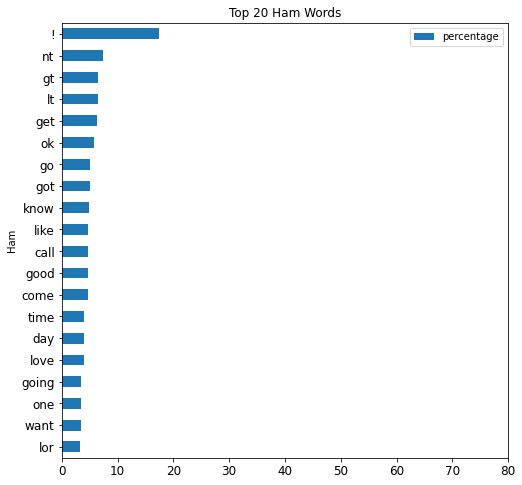

In [60]:
hamorder_sorted.plot.barh(xlim=(0,80),  y='percentage', x='Ham',figsize=(8,8),title= 'Top 20 Ham Words',fontsize=12)

In [491]:

hamdf = pd.DataFrame(hamwords)

hamdf


clean_msg
0     [go, jurong, point, crazy, available, bugis, n...
1                                     [ok, lar, joking]
3                  [dun, say, early, hor, already, say]
4     [nah, nt, think, goes, usf, lives, around, tho...
6     [even, brother, like, speak, treat, like, aids...
...                                                 ...
5565                                         [huh, lei]
5568                    [ì, going, esplanade, fr, home]
5569                          [pity, mood, suggestions]
5570  [guy, bitching, acted, like, interested, buyin...
5571                                 [rofl, true, name]

[4825 rows x 1 columns]

In [660]:
hamtext = df[df.Spam== 0].clean_msg
#print (hamtext)

hamtext = " ".join(review for review in hamtext)
#print (hamtext)

#print ("There are {} words in the combination of all review.".format(len(hamtext)))



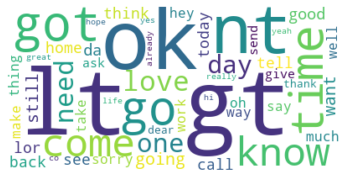

In [505]:

# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=50, background_color="white").generate(hamtext)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [30]:
spamwords = df[df.Spam== 1].clean_msg.apply(lambda x: x.split())

print(spamwords)

spam_words = Counter()

for msg in spamwords:
    spam_words.update(msg)
    
print(spam_words.most_common(20))   
Spamcommon = spam_words.most_common(20)

2       [free, entry, wkly, comp, win, fa, cup, final,...
5       [freemsg, hey, darling, week, word, back, !, l...
8       [winner, !, !, valued, network, customer, sele...
9       [mobile, months, entitled, update, latest, col...
11      [six, chances, win, cash, !, pounds, txt, send...
                              ...                        
5537    [want, explicit, sex, secs, ring, !, costs, gs...
5540    [asked, chatlines, inclu, free, mins, india, c...
5547    [contract, mobile, mnths, latest, motorola, no...
5566    [reminder, get, pounds, free, call, credit, de...
5567    [time, tried, contact, pound, prize, claim, ea...
Name: clean_msg, Length: 747, dtype: object
[('!', 542), ('call', 347), ('free', 219), ('txt', 156), ('mobile', 123), ('text', 121), ('stop', 116), ('claim', 113), ('reply', 104), ('prize', 92), ('get', 84), ('new', 69), ('send', 68), ('nokia', 65), ('urgent', 63), ('cash', 62), ('win', 60), ('contact', 56), ('service', 55), ('please', 54)]


In [31]:
Spamcommondf = pd.DataFrame(Spamcommon)
Spamcommondf

0    1
0         !  542
1      call  347
2      free  219
3       txt  156
4    mobile  123
5      text  121
6      stop  116
7     claim  113
8     reply  104
9     prize   92
10      get   84
11      new   69
12     send   68
13    nokia   65
14   urgent   63
15     cash   62
16      win   60
17  contact   56
18  service   55
19   please   54

In [32]:
Spamcommondf = pd.DataFrame(Spamcommon)
Spamcommondf = Spamcommondf.rename(columns={0: "Spam", 1: "Count"})


In [35]:
Spamorder_sorted = Spamcommondf.iloc[Spamcommondf['Count'].argsort()]
Spamorder_sorted = Spamorder_sorted.reset_index(drop=True)
Spamorder_sorted.set_index('Spam')

Spamorder_sorted['percentage']= (Spamorder_sorted['Count']/747)*100

Spamorder_sorted

Spam  Count  percentage
0    please     54    7.228916
1   service     55    7.362784
2   contact     56    7.496653
3       win     60    8.032129
4      cash     62    8.299866
5    urgent     63    8.433735
6     nokia     65    8.701473
7      send     68    9.103079
8       new     69    9.236948
9       get     84   11.244980
10    prize     92   12.315930
11    reply    104   13.922356
12    claim    113   15.127175
13     stop    116   15.528782
14     text    121   16.198126
15   mobile    123   16.465863
16      txt    156   20.883534
17     free    219   29.317269
18     call    347   46.452477
19        !    542   72.556894

<AxesSubplot:title={'center':'Top 20 Spam Words'}, ylabel='Spam'>

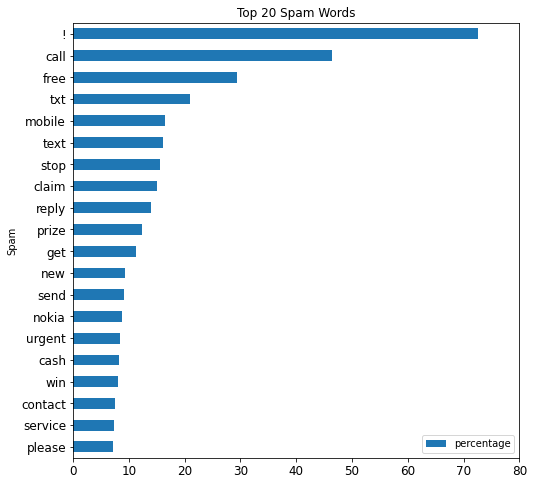

In [59]:
Spamorder_sorted.plot.barh(xlim=(0,80),y='percentage', x='Spam',figsize=(8,8),title= 'Top 20 Spam Words',fontsize=12)

In [500]:
spamtext = df[df.Spam== 1].clean_msg
#print (hamtext)

spamtext = " ".join(review for review in spamtext)
#print (spamtext)

#print ("There are {} words in the combination of all review.".format(len(hamtext)))


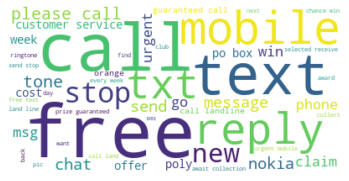

In [506]:

# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=50, background_color="white").generate(spamtext)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [503]:
from PIL import Image

phone_mask = np.array(Image.open("pics/download.png"))
phone_mask

array([[2, 0, 2, ..., 2, 0, 2],
       [0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 2],
       ...,
       [2, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 0],
       [2, 0, 2, ..., 2, 0, 2]], dtype=uint8)

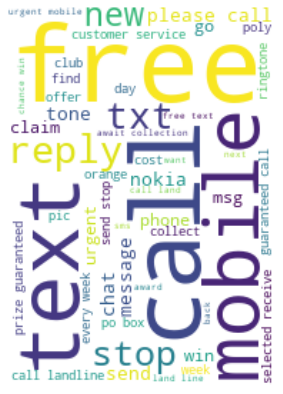

In [508]:
# Create a word cloud image
wc = WordCloud(background_color="white", max_words=50, mask=phone_mask,
               contour_color='black')

# Generate a wordcloud
wc.generate(spamtext)

# store to file
wc.to_file("pics/download1.png")

# show
plt.figure(figsize=[15,7])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [210]:
# Split the data into X and y data sets
X = df.clean_msg
y = df.Spam

In [211]:
# hold out 20% of the data for final testing, random state 123 for identifying
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)



In [685]:
# The first document-term matrix has default Count Vectorizer values - counts of unigrams

cv = CountVectorizer()

X_train_cv = cv.fit_transform(X_train)
X_test_cv  = cv.transform(X_test)

pd.DataFrame(X_train_cv.toarray(), index = X_train, columns=cv.get_feature_names()).head()

aa  aah  aathi  ab  abbey  \
clean_msg                                                                       
took mr owl licks                                    0    0      0   0      0   
well pattern emerging friends telling drive com...   0    0      0   0      0   
yes thought thanks                                   0    0      0   0      0   
urgent ! mobile number bonus caller prize ! att...   0    0      0   0      0   
aiyah sorry lor watch tv watch forgot check phone    0    0      0   0      0   

                                                    abdomen  abeg  abel  \
clean_msg                                                                 
took mr owl licks                                         0     0     0   
well pattern emerging friends telling drive com...        0     0     0   
yes thought thanks                                        0     0     0   
urgent ! mobile number bonus caller prize ! att...        0     0     0   
aiyah sorry lor watch tv watch forgot check phone         0     0     0   

                                                    aberdeen  abi  ...  åòit  \
clean_msg                                                          ...         
took mr owl licks                                          0    0  ...     0   
well pattern emerging friends telling drive com...         0    0  ...     0   
yes thought thanks                                         0    0  ...     0   
urgent ! mobile number bonus caller prize ! att...         0    0  ...     0   
aiyah sorry lor watch tv watch forgot check phone          0    0  ...     0   

                                                    åômorrow  åôrents  ìï  \
clean_msg                                                                   
took mr owl licks                                          0        0   0   
well pattern emerging friends telling drive com...         0        0   0   
yes thought thanks                                         0        0   0   
urgent ! mobile number bonus caller prize ! att...         0        0   0   
aiyah sorry lor watch tv watch forgot check phone          0        0   0   

                                                    ûthanks  ûªm  ûªt  ûªve  \
clean_msg                                                                     
took mr owl licks                                         0    0    0     0   
well pattern emerging friends telling drive com...        0    0    0     0   
yes thought thanks                                        0    0    0     0   
urgent ! mobile number bonus caller prize ! att...        0    0    0     0   
aiyah sorry lor watch tv watch forgot check phone         0    0    0     0   

                                                    ûò  ûówell  
clean_msg                                                       
took mr owl licks                                    0       0  
well pattern emerging friends telling drive com...   0       0  
yes thought thanks                                   0       0  
urgent ! mobile number bonus caller prize ! att...   0       0  
aiyah sorry lor watch tv watch forgot check phone    0       0  

[5 rows x 6728 columns]

In [69]:
# Create a logistic regression model to use

logistic_cv = linear_model.LogisticRegression(max_iter = 1000)
logistic_tfidf = linear_model.LogisticRegression(max_iter = 1000)
logistic_cvlsa = linear_model.LogisticRegression(max_iter = 1000)
logistic_tfidflsa = linear_model.LogisticRegression(max_iter = 1000)

# Create regularization penalty space
penalty = ['l1', 'l2']
solver = ['liblinear','lbfgs']
# Create regularization hyperparameter space
C_log = np.logspace(0, 10, 100)

# Create hyperparameter options
hyperparameters_log = dict(C=C_log, penalty=penalty, solver = solver)

#cv_method = RepeatedStratifiedKFold(n_splits=10, 
                                    n_repeats=3, 
                                    random_state=999)

In [76]:
# Train the logistic regression model
# Create grid search using 10-fold cross validation
gridcv_logistic = GridSearchCV(logistic_cv, hyperparameters_log, cv=10, verbose=0 )

# Fit grid search
gridcv_logistic.fit(X_train_cv, y_train)



C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': array([1.00000000e+00, 1.26185688e+00, 1.59228279e+00, 2.00923300e+00,
       2.53536449e+00, 3.19926714e+00, 4.03701726e+00, 5.09413801e+00,
       6.42807312e+00, 8.11130831e+00, 1.02353102e+01, 1.29154967e+01,
       1.62975083e+01, 2.05651231e+01, 2.59502421e+01, 3.27454916e+01,
       4.13201240e+01, 5.2140082...
       1.20450354e+08, 1.51991108e+08, 1.91791026e+08, 2.42012826e+08,
       3.05385551e+08, 3.85352859e+08, 4.86260158e+08, 6.13590727e+08,
       7.74263683e+08, 9.77009957e+08, 1.23284674e+09, 1.55567614e+09,
       1.96304065e+09, 2.47707636e+09, 3.12571585e+09, 3.94420606e+09,
       4.97702356e+09, 6.28029144e+09, 7.92482898e+09, 1.00000000e+10]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs']})

In [77]:
gridcv_logistic.best_params_

{'C': 83.02175681319744, 'penalty': 'l2', 'solver': 'liblinear'}

In [78]:
gridlogcv_predict = gridcv_logistic.predict(X_test_cv)
print(classification_report(y_test,gridlogcv_predict))
print(confusion_matrix(y_test, gridlogcv_predict))
roc_auc_score(y_test, gridlogcv_predict)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       982
           1       1.00      0.86      0.92       133

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115

[[982   0]
 [ 19 114]]


0.9285714285714286

In [104]:
# Create a function to calculate the error metrics, since we'll be doing this several times


def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_notspam', 'predicted_spam'], 
                yticklabels=['actual_notspam', 'actual_spam'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

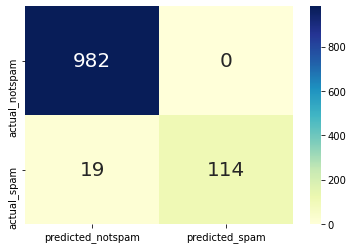

In [105]:
# The heat map for the logistic regression model
cm_cvlog = conf_matrix(y_test, gridlogcv_predict)

In [635]:
LRcv_probability_class_1 = gridcv_logistic.predict_proba(X_test_cv)[:, 1]  
#lists the probabilities that the X_test values will lead to churn =1 

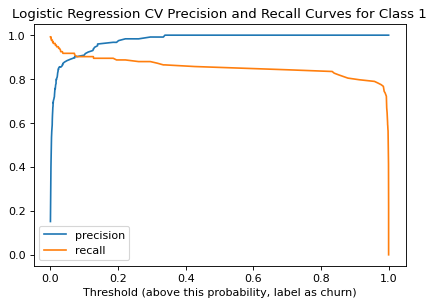

In [594]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, probability_class_1)

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as churn)');
plt.title('Logistic Regression CV Precision and Recall Curves for Class 1');

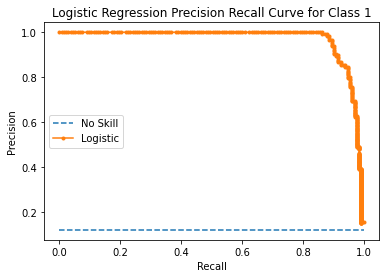

In [595]:

# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall_curve, precision_curve, marker='.', label='Logistic')
pyplot.title('Logistic Regression Precision Recall Curve for Class 1')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.989


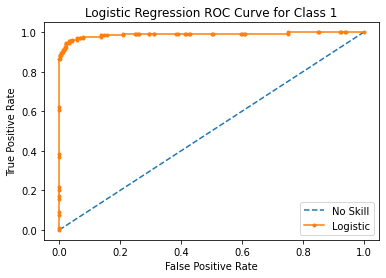

In [596]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_roc_auc = roc_auc_score(y_test, probability_class_1)  
#use the roc_auc_score() function to calculate the true-positive rate and false-positive rate for the predictions 
#using a set of thresholds that can then be used to create a ROC Curve plot.

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_roc_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, probability_class_1)


# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')


pyplot.title('Logistic Regression ROC Curve for Class 1');
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [597]:
print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, probability_class_1)))

Log-loss on logit: 0.0670


In [770]:
#Use matrix factorization (LSA) on CV transformed X values to improve model.The objective of LSA is reducing dimension for classification.

# Standardize the features


lsa = TruncatedSVD(n_components=2, n_iter=100, random_state=1)

X_train_cvlsa = lsa.fit_transform(X_train_cv)

print(lsa.explained_variance_ratio_)

print(lsa.explained_variance_ratio_.sum())

print(lsa.singular_values_)


#Sigma = lsa.singular_values_
#V_T = lsa.components_.T

#sns.barplot(x=list(range(len(Sigma))), y = Sigma)

[0.0162626 0.0165054]
0.032768006224292795
[30.50562164 27.26512032]


In [771]:
topic_word_cvlsa = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2"],
             columns = cv.get_feature_names())

topic_word_cvlsa

aa  aah  aathi   ab  abbey  abdomen  abeg  abel  aberdeen  \
component_1  0.0  0.0    0.0  0.0    0.0      0.0   0.0   0.0       0.0   
component_2 -0.0 -0.0   -0.0 -0.0   -0.0     -0.0  -0.0  -0.0      -0.0   

               abi  ...   åòit  åômorrow  åôrents     ìï  ûthanks  ûªm  ûªt  \
component_1  0.002  ...  0.000       0.0      0.0  0.007      0.0  0.0  0.0   
component_2  0.001  ... -0.001      -0.0     -0.0 -0.005     -0.0 -0.0 -0.0   

              ûªve     ûò  ûówell  
component_1  0.001  0.001     0.0  
component_2 -0.001 -0.001    -0.0  

[2 rows x 6728 columns]

In [772]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [773]:
display_topics(lsa, cv.get_feature_names(), 20)


Topic  0
gt, lt, call, nt, get, free, know, like, time, go, send, got, reply, mobile, want, text, come, day, stop, love

Topic  1
gt, lt, decimal, police, says, india, rs, went, dis, transaction, bank, face, money, politicians, crore, swiss, indians, poor, wife, yrs


In [36]:
Vt = pd.DataFrame(X_train_cvlsa.round(50), index = X_train, columns = ["component_1","component_2" ])
Vt

component_1  component_2
clean_msg                                                                   
took mr owl licks                                      0.017010     0.007936
well pattern emerging friends telling drive com...     0.216012    -0.101481
yes thought thanks                                     0.043227    -0.047987
urgent ! mobile number bonus caller prize ! att...     0.522833    -0.978168
aiyah sorry lor watch tv watch forgot check phone      0.150124    -0.160597
...                                                         ...          ...
accidentally brought em home box                       0.053022    -0.055947
aight set free think could text blake address o...     0.350037    -0.413632
ok stay night xavier sleeping bag getting tired        0.120299    -0.061104
need lar jus testing phone card dunno network g...     0.202043    -0.168440
sent maga money yesterday oh                           0.100153    -0.004803

[4457 rows x 2 columns]

In [36]:
Vt = pd.DataFrame(X_train_cvlsa.round(50), index = X_train, columns = ["component_1","component_2" ])
Vt

component_1  component_2
clean_msg                                                                   
took mr owl licks                                      0.017010     0.007936
well pattern emerging friends telling drive com...     0.216012    -0.101481
yes thought thanks                                     0.043227    -0.047987
urgent ! mobile number bonus caller prize ! att...     0.522833    -0.978168
aiyah sorry lor watch tv watch forgot check phone      0.150124    -0.160597
...                                                         ...          ...
accidentally brought em home box                       0.053022    -0.055947
aight set free think could text blake address o...     0.350037    -0.413632
ok stay night xavier sleeping bag getting tired        0.120299    -0.061104
need lar jus testing phone card dunno network g...     0.202043    -0.168440
sent maga money yesterday oh                           0.100153    -0.004803

[4457 rows x 2 columns]

In [37]:
# Train the logistic regression model
# Create grid search using 10-fold cross validation
gridcvlsa_logistic = GridSearchCV(logistic_cvlsa, hyperparameters_log, cv=10, verbose=0 )

# Fit grid search
gridcvlsa_logistic.fit(X_train_cvlsa, y_train)

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': array([1.00000000e+00, 1.26185688e+00, 1.59228279e+00, 2.00923300e+00,
       2.53536449e+00, 3.19926714e+00, 4.03701726e+00, 5.09413801e+00,
       6.42807312e+00, 8.11130831e+00, 1.02353102e+01, 1.29154967e+01,
       1.62975083e+01, 2.05651231e+01, 2.59502421e+01, 3.27454916e+01,
       4.13201240e+01, 5.2140082...
       1.20450354e+08, 1.51991108e+08, 1.91791026e+08, 2.42012826e+08,
       3.05385551e+08, 3.85352859e+08, 4.86260158e+08, 6.13590727e+08,
       7.74263683e+08, 9.77009957e+08, 1.23284674e+09, 1.55567614e+09,
       1.96304065e+09, 2.47707636e+09, 3.12571585e+09, 3.94420606e+09,
       4.97702356e+09, 6.28029144e+09, 7.92482898e+09, 1.00000000e+10]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs']})

In [38]:
gridcvlsa_logistic.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}

In [39]:
X_test_cvlsa = lsa.transform(X_test_cv)

In [40]:
gridlogcvlsa_predict = gridcvlsa_logistic.predict(X_test_cvlsa)
print(classification_report(y_test,gridlogcvlsa_predict))
print(confusion_matrix(y_test, gridlogcvlsa_predict))
roc_auc_score(y_test, gridlogcvlsa_predict)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       982
           1       0.66      0.49      0.56       133

    accuracy                           0.91      1115
   macro avg       0.79      0.73      0.75      1115
weighted avg       0.90      0.91      0.90      1115

[[948  34]
 [ 68  65]]


0.7270492932943358

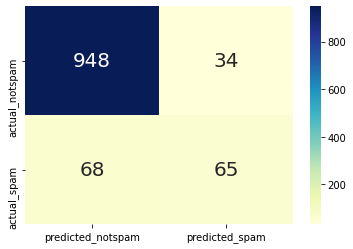

In [41]:
# The heat map for the logistic regression model of cv_lsa vectors
cm_cvlsalog = conf_matrix(y_test, gridlogcvlsa_predict)

In [42]:
#tfidf

In [43]:
# Create TF-IDF vectors

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

pd.DataFrame(X_train_tfidf.toarray(), index = X_train, columns=tfidf.get_feature_names()).head()

aa  aah  aathi   ab  \
clean_msg                                                                  
took mr owl licks                                   0.0  0.0    0.0  0.0   
well pattern emerging friends telling drive com...  0.0  0.0    0.0  0.0   
yes thought thanks                                  0.0  0.0    0.0  0.0   
urgent ! mobile number bonus caller prize ! att...  0.0  0.0    0.0  0.0   
aiyah sorry lor watch tv watch forgot check phone   0.0  0.0    0.0  0.0   

                                                    abbey  abdomen  abeg  \
clean_msg                                                                  
took mr owl licks                                     0.0      0.0   0.0   
well pattern emerging friends telling drive com...    0.0      0.0   0.0   
yes thought thanks                                    0.0      0.0   0.0   
urgent ! mobile number bonus caller prize ! att...    0.0      0.0   0.0   
aiyah sorry lor watch tv watch forgot check phone     0.0      0.0   0.0   

                                                    abel  aberdeen  abi  ...  \
clean_msg                                                                ...   
took mr owl licks                                    0.0       0.0  0.0  ...   
well pattern emerging friends telling drive com...   0.0       0.0  0.0  ...   
yes thought thanks                                   0.0       0.0  0.0  ...   
urgent ! mobile number bonus caller prize ! att...   0.0       0.0  0.0  ...   
aiyah sorry lor watch tv watch forgot check phone    0.0       0.0  0.0  ...   

                                                    åòit  åômorrow  åôrents  \
clean_msg                                                                     
took mr owl licks                                    0.0       0.0      0.0   
well pattern emerging friends telling drive com...   0.0       0.0      0.0   
yes thought thanks                                   0.0       0.0      0.0   
urgent ! mobile number bonus caller prize ! att...   0.0       0.0      0.0   
aiyah sorry lor watch tv watch forgot check phone    0.0       0.0      0.0   

                                                     ìï  ûthanks  ûªm  ûªt  \
clean_msg                                                                    
took mr owl licks                                   0.0      0.0  0.0  0.0   
well pattern emerging friends telling drive com...  0.0      0.0  0.0  0.0   
yes thought thanks                                  0.0      0.0  0.0  0.0   
urgent ! mobile number bonus caller prize ! att...  0.0      0.0  0.0  0.0   
aiyah sorry lor watch tv watch forgot check phone   0.0      0.0  0.0  0.0   

                                                    ûªve   ûò  ûówell  
clean_msg                                                              
took mr owl licks                                    0.0  0.0     0.0  
well pattern emerging friends telling drive com...   0.0  0.0     0.0  
yes thought thanks                                   0.0  0.0     0.0  
urgent ! mobile number bonus caller prize ! att...   0.0  0.0     0.0  
aiyah sorry lor watch tv watch forgot check phone    0.0  0.0     0.0  

[5 rows x 6728 columns]

[0.00745493 0.00972332]
0.017178244210492636
[7.16072056 6.60165532]


<AxesSubplot:>

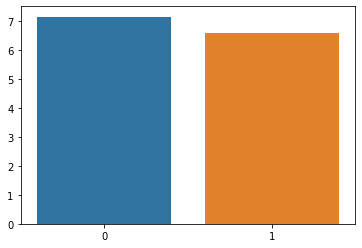

In [690]:
#Use matrix factorization (LSA) on tfidf transformed X values to improve model.The objective of LSA is reducing dimension for classification.

lsatfidf = TruncatedSVD(n_components=2, n_iter=100, random_state=123)
X_train_tfidflsa = lsatfidf.fit_transform(X_train_tfidf)

print(lsatfidf.explained_variance_ratio_)

print(lsatfidf.explained_variance_ratio_.sum())

print(lsatfidf.singular_values_)

Sigmatfidf = lsatfidf.singular_values_
V_Ttfidf = lsatfidf.components_.T

sns.barplot(x=list(range(len(Sigmatfidf))), y = Sigmatfidf)

In [691]:
topic_word_tfidflsa = pd.DataFrame(lsatfidf.components_.round(3),
             index = ["component_1","component_2"],
             columns = tfidf.get_feature_names())

topic_word_tfidflsa

aa  aah  aathi   ab  abbey  abdomen  abeg  abel  aberdeen  \
component_1  0.0  0.0  0.001  0.0    0.0      0.0   0.0   0.0       0.0   
component_2  0.0  0.0  0.000 -0.0   -0.0      0.0   0.0  -0.0       0.0   

               abi  ...   åòit  åômorrow  åôrents     ìï  ûthanks  ûªm  ûªt  \
component_1  0.001  ...  0.001       0.0      0.0  0.018      0.0  0.0  0.0   
component_2  0.000  ... -0.000       0.0      0.0  0.011      0.0  0.0  0.0   

              ûªve     ûò  ûówell  
component_1  0.001  0.002   0.001  
component_2 -0.001  0.002   0.000  

[2 rows x 6728 columns]

In [ ]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [692]:
display_topics(lsatfidf, tfidf.get_feature_names(), 50)


Topic  0
call, ok, later, sorry, free, lt, gt, get, meeting, come, lor, please, home, nt, time, prize, go, claim, know, got, good, mobile, urgent, like, going, da, send, tell, message, text, want, new, tomorrow, oh, pls, phone, back, customer, number, reply, still, guaranteed, ill, sir, hi, see, contact, need, take, waiting

Topic  1
ok, lor, come, go, gt, home, lt, thanx, oh, like, prob, need, take, wan, ask, leave, anything, get, good, going, dinner, ya, tell, coming, ill, msg, time, already, enjoy, way, got, said, know, house, tomorrow, wait, thk, yup, sleep, one, na, hope, finish, lar, send, ard, care, dun, say, morning


In [44]:
# Train the logistic regression model using tfidf vectors
# Create grid search using 10-fold cross validation
gridtfidf_logistic = GridSearchCV(logistic_tfidf, hyperparameters_log, cv=10, verbose=0 )

# Fit grid search
gridtfidf_logistic.fit(X_train_tfidf, y_train)

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or '

C:\LSY\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or '

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': array([1.00000000e+00, 1.26185688e+00, 1.59228279e+00, 2.00923300e+00,
       2.53536449e+00, 3.19926714e+00, 4.03701726e+00, 5.09413801e+00,
       6.42807312e+00, 8.11130831e+00, 1.02353102e+01, 1.29154967e+01,
       1.62975083e+01, 2.05651231e+01, 2.59502421e+01, 3.27454916e+01,
       4.13201240e+01, 5.2140082...
       1.20450354e+08, 1.51991108e+08, 1.91791026e+08, 2.42012826e+08,
       3.05385551e+08, 3.85352859e+08, 4.86260158e+08, 6.13590727e+08,
       7.74263683e+08, 9.77009957e+08, 1.23284674e+09, 1.55567614e+09,
       1.96304065e+09, 2.47707636e+09, 3.12571585e+09, 3.94420606e+09,
       4.97702356e+09, 6.28029144e+09, 7.92482898e+09, 1.00000000e+10]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs']})

In [45]:
gridtfidf_logistic.best_params_

{'C': 673.4150657750821, 'penalty': 'l2', 'solver': 'liblinear'}

In [46]:
gridlogtfidf_predict = gridtfidf_logistic.predict(X_test_tfidf)
print(classification_report(y_test, gridlogtfidf_predict))
print(confusion_matrix(y_test, gridlogtfidf_predict))
roc_auc_score(y_test, gridlogtfidf_predict)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       982
           1       0.98      0.90      0.94       133

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115

[[980   2]
 [ 13 120]]


0.9501094896099719

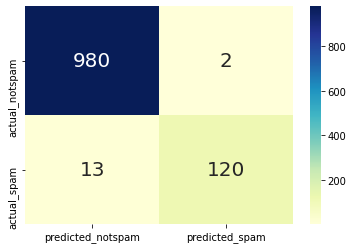

In [47]:
# The heat map for the logistic regression model
cm_tfidflog = conf_matrix(y_test, gridlogtfidf_predict)

In [48]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm_cvlog, cm_cvlsalog, cm_tfidflog)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg_CV', 'LogReg_CV_LSA', 'LogReg_tfidf']
results

LogReg_CV  LogReg_CV_LSA  LogReg_tfidf
Accuracy       0.983          0.909         0.987
Precision      1.000          0.657         0.984
Recall         0.857          0.489         0.902
F1 Score       0.923          0.561         0.941

In [636]:
LRtfidf_probability_class_1 = gridtfidf_logistic.predict_proba(X_test_tfidf)[:, 1]  

In [609]:
print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, probability_class_1)))

Log-loss on logit: 0.0556


In [49]:
#tfidf_lsa model

[0.00745493 0.00972332]
0.017178244210492636
[7.16072056 6.60165532]


<AxesSubplot:>

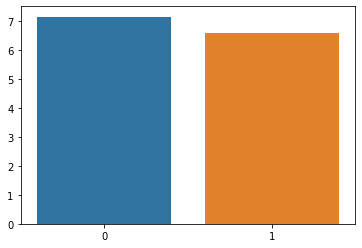

In [50]:
#Use matrix factorization (LSA) on tfidf transformed X values to improve model.The objective of LSA is reducing dimension for classification.

lsa = TruncatedSVD(n_components=2, n_iter=100, random_state=123)
X_train_tfidflsa = lsa.fit_transform(X_train_tfidf)

print(lsa.explained_variance_ratio_)

print(lsa.explained_variance_ratio_.sum())

print(lsa.singular_values_)

Sigma = lsa.singular_values_
V_T = lsa.components_.T

sns.barplot(x=list(range(len(Sigma))), y = Sigma)

In [51]:
topic_word_tfidflsa = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2"],
             columns = tfidf.get_feature_names())

topic_word_tfidflsa

aa  aah  aathi   ab  abbey  abdomen  abeg  abel  aberdeen  \
component_1  0.0  0.0  0.001  0.0    0.0      0.0   0.0   0.0       0.0   
component_2  0.0  0.0  0.000 -0.0   -0.0      0.0   0.0  -0.0       0.0   

               abi  ...   åòit  åômorrow  åôrents     ìï  ûthanks  ûªm  ûªt  \
component_1  0.001  ...  0.001       0.0      0.0  0.018      0.0  0.0  0.0   
component_2  0.000  ... -0.000       0.0      0.0  0.011      0.0  0.0  0.0   

              ûªve     ûò  ûówell  
component_1  0.001  0.002   0.001  
component_2 -0.001  0.002   0.000  

[2 rows x 6728 columns]

In [52]:
Vt_tfidflsa = pd.DataFrame(X_train_tfidflsa.round(50), index = X_train, columns = ["component_1","component_2" ])
Vt_tfidflsa

component_1  component_2
clean_msg                                                                   
took mr owl licks                                      0.003168     0.001714
well pattern emerging friends telling drive com...     0.029869     0.013692
yes thought thanks                                     0.027472     0.002792
urgent ! mobile number bonus caller prize ! att...     0.185396    -0.102170
aiyah sorry lor watch tv watch forgot check phone      0.127821    -0.008782
...                                                         ...          ...
accidentally brought em home box                       0.033575     0.009794
aight set free think could text blake address o...     0.061057     0.001700
ok stay night xavier sleeping bag getting tired        0.101108     0.198235
need lar jus testing phone card dunno network g...     0.049293     0.019172
sent maga money yesterday oh                           0.032741     0.020191

[4457 rows x 2 columns]

In [53]:
# Train the logistic regression model
# Create grid search using 10-fold cross validation
gridtfidflsa_logistic = GridSearchCV(logistic_tfidflsa, hyperparameters_log, cv=10, verbose=0 )

# Fit grid search
gridtfidflsa_logistic.fit(X_train_tfidflsa, y_train)

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': array([1.00000000e+00, 1.26185688e+00, 1.59228279e+00, 2.00923300e+00,
       2.53536449e+00, 3.19926714e+00, 4.03701726e+00, 5.09413801e+00,
       6.42807312e+00, 8.11130831e+00, 1.02353102e+01, 1.29154967e+01,
       1.62975083e+01, 2.05651231e+01, 2.59502421e+01, 3.27454916e+01,
       4.13201240e+01, 5.2140082...
       1.20450354e+08, 1.51991108e+08, 1.91791026e+08, 2.42012826e+08,
       3.05385551e+08, 3.85352859e+08, 4.86260158e+08, 6.13590727e+08,
       7.74263683e+08, 9.77009957e+08, 1.23284674e+09, 1.55567614e+09,
       1.96304065e+09, 2.47707636e+09, 3.12571585e+09, 3.94420606e+09,
       4.97702356e+09, 6.28029144e+09, 7.92482898e+09, 1.00000000e+10]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs']})

In [54]:
gridtfidflsa_logistic.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}

In [55]:
X_test_tfidflsa = lsa.transform(X_test_tfidf)

In [56]:
gridlogtfidflsa_predict = gridtfidflsa_logistic.predict(X_test_tfidflsa)
print(classification_report(y_test, gridlogtfidflsa_predict))
print(confusion_matrix(y_test, gridlogtfidflsa_predict))
roc_auc_score(y_test, gridlogtfidflsa_predict)

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       982
           1       0.00      0.00      0.00       133

    accuracy                           0.87      1115
   macro avg       0.44      0.50      0.47      1115
weighted avg       0.77      0.87      0.82      1115

[[974   8]
 [133   0]]


0.4959266802443992

<ipython-input-30-e49086951d0a>:16: RuntimeWarning: invalid value encountered in double_scalars
  f1 = round(2 * (precision * recall) / (precision + recall),3)


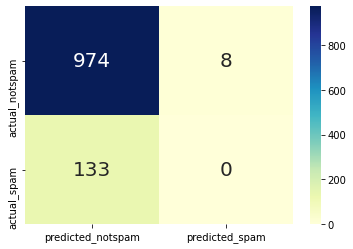

In [57]:
# The heat map for the logistic regression model of tfidf_lsa vectors
cm_tfidflsalog = conf_matrix(y_test, gridlogtfidflsa_predict)

In [60]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm_cvlog, cm_cvlsalog, cm_tfidflog, cm_tfidflsalog)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg_CV', 'LogReg_CV_LSA', 'LogReg_tfidf', 'LogReg_tfidf_LSA']
results

LogReg_CV  LogReg_CV_LSA  LogReg_tfidf  LogReg_tfidf_LSA
Accuracy       0.983          0.909         0.987             0.874
Precision      1.000          0.657         0.984             0.000
Recall         0.857          0.489         0.902             0.000
F1 Score       0.923          0.561         0.941               NaN

In [ ]:
#Try other classifiers 

In [ ]:
#knn classifier

In [124]:
#train KNN model based on cv vectors
# Create grid search using 10-fold cross validation
k_range = list(range(1, 31))

params_KNN = {'n_neighbors': k_range, 'p': [1, 2, 5]}
#cv_method = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=999)

gridcv_KNN = GridSearchCV(estimator= KNeighborsClassifier(), param_grid = params_KNN, cv=10, verbose=1, scoring='accuracy', return_train_score=True)

# Fit grid search
gridcv_KNN.fit(X_train_cv, y_train)


Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:5

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'p': [1, 2, 5]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [125]:
gridcv_KNN.best_params_

{'n_neighbors': 3, 'p': 1}

In [126]:
gridKNNcv_predict = gridcv_KNN.predict(X_test_cv)
print(classification_report(y_test, gridKNNcv_predict))
print(confusion_matrix(y_test, gridKNNcv_predict))
roc_auc_score(y_test, gridKNNcv_predict)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       982
           1       0.99      0.63      0.77       133

    accuracy                           0.96      1115
   macro avg       0.97      0.82      0.87      1115
weighted avg       0.96      0.96      0.95      1115

[[981   1]
 [ 49  84]]


0.8152803087147604

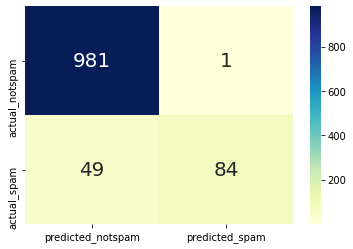

In [127]:
cm_cvknn = conf_matrix(y_test, gridKNNcv_predict)

In [637]:
KNNcv_probability_class_1 = gridcv_KNN.predict_proba(X_test_cv)[:, 1]  

In [626]:
print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, probability_class_1)))

Log-loss on logit: 0.6861


In [129]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm_cvlog, cm_cvlsalog, cm_tfidflog, cm_cvknn)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg_CV', 'LogReg_CV_LSA', 'LogReg_tfidf', 'kNN_CV']
results

LogReg_CV  LogReg_CV_LSA  LogReg_tfidf  kNN_CV
Accuracy       0.983          0.909         0.987   0.955
Precision      1.000          0.657         0.984   0.988
Recall         0.857          0.489         0.902   0.632
F1 Score       0.923          0.561         0.941   0.771

In [107]:
# train naive bayes model, bernoulli NB

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}

gridcv_BerNB = GridSearchCV(BernoulliNB(), param_grid=params, n_jobs=-1, cv=10, verbose=5)
gridcv_BerNB.fit(X_train_cv, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  50 | elapsed:    2.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.0s finished


GridSearchCV(cv=10, estimator=BernoulliNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}, verbose=5)

In [108]:
gridcv_BerNB.best_params_

{'alpha': 0.01}

In [111]:
gridcvBerNB_predict = gridcv_BerNB.predict(X_test_cv)
print(classification_report(y_test, gridcvBerNB_predict))
print(confusion_matrix(y_test, gridcvBerNB_predict))
roc_auc_score(y_test, gridcvBerNB_predict)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       982
           1       1.00      0.93      0.96       133

    accuracy                           0.99      1115
   macro avg       1.00      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115

[[982   0]
 [  9 124]]


0.9661654135338346

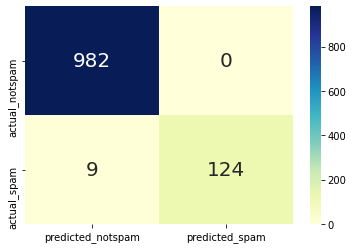

In [112]:
# The heat map for the BernoulliNB model
cm_cvBerNB = conf_matrix(y_test, gridcvBerNB_predict)

In [638]:
BerNBcv_probability_class_1 = gridcv_BerNB.predict_proba(X_test_cv)[:, 1]  
#lists the probabilities that the X_test values will lead to churn =1 

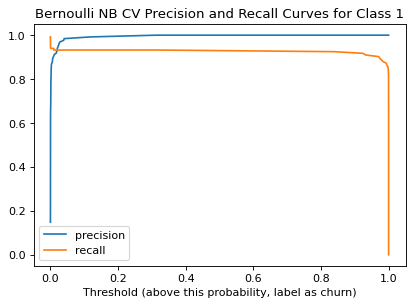

In [600]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, probability_class_1)

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as churn)');
plt.title('Bernoulli NB CV Precision and Recall Curves for Class 1');

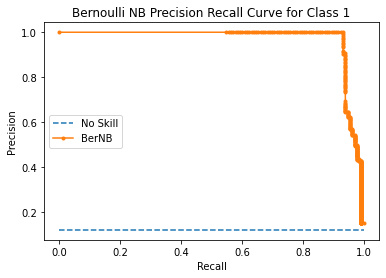

In [601]:

# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall_curve, precision_curve, marker='.', label='BerNB')
pyplot.title('Bernoulli NB Precision Recall Curve for Class 1')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

No Skill: ROC AUC=0.500
BerNB: ROC AUC=0.988


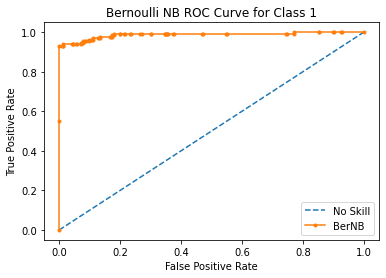

In [603]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_roc_auc = roc_auc_score(y_test, probability_class_1)  
#use the roc_auc_score() function to calculate the true-positive rate and false-positive rate for the predictions 
#using a set of thresholds that can then be used to create a ROC Curve plot.

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('BerNB: ROC AUC=%.3f' % (lr_roc_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, probability_class_1)


# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='BerNB')


pyplot.title('Bernoulli NB ROC Curve for Class 1');
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [604]:
print("Log-loss on BerNB: {:6.4f}".format(log_loss(y_test, probability_class_1)))

Log-loss on BerNB: 0.0928


In [ ]:
#train naive bayes model, ComplementNB (for imbalanced dataset)

In [113]:
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}

gridcv_ComBerNB = GridSearchCV(ComplementNB(), param_grid=params, n_jobs=-1, cv=10, verbose=5)
gridcv_ComBerNB.fit(X_train_cv, y_train)


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  50 | elapsed:    1.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.9s finished


GridSearchCV(cv=10, estimator=ComplementNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}, verbose=5)

In [114]:
gridcv_ComBerNB.best_params_

{'alpha': 0.01}

In [115]:
gridcvComBerNB_predict = gridcv_ComBerNB.predict(X_test_cv)
print(classification_report(y_test, gridcvComBerNB_predict))
print(confusion_matrix(y_test, gridcvComBerNB_predict))
roc_auc_score(y_test, gridcvComBerNB_predict)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       982
           1       0.86      0.93      0.90       133

    accuracy                           0.97      1115
   macro avg       0.93      0.96      0.94      1115
weighted avg       0.98      0.97      0.97      1115

[[962  20]
 [  9 124]]


0.9559821141448325

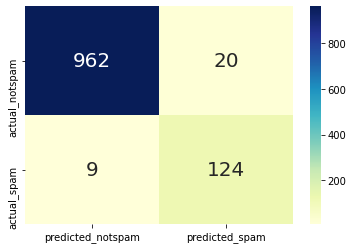

In [116]:
# The heat map for the BernoulliNB model
cm_cvComBerNB = conf_matrix(y_test, gridcvComBerNB_predict)

In [639]:
ComNBcv_probability_class_1 = gridcv_ComBerNB.predict_proba(X_test_cv)[:, 1]  

In [615]:
print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, probability_class_1)))

Log-loss on logit: 0.1295


In [118]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm_cvlog, cm_cvlsalog, cm_tfidflog, cm_cvknn, cm_cvBerNB, cm_cvComBerNB )))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg_CV', 'LogReg_CV_LSA', 'LogReg_tfidf', 'kNN_CV', 'BernoulliNB_CV', 'ComplementNB_CV']
results

LogReg_CV  LogReg_CV_LSA  LogReg_tfidf  kNN_CV  BernoulliNB_CV  \
Accuracy       0.983          0.909         0.987   0.945           0.992   
Precision      1.000          0.657         0.984   1.000           1.000   
Recall         0.857          0.489         0.902   0.541           0.932   
F1 Score       0.923          0.561         0.941   0.702           0.965   

           ComplementNB_CV  
Accuracy             0.974  
Precision            0.861  
Recall               0.932  
F1 Score             0.895

In [119]:
#creates random forest classifier with GridSearchCV

rfc=RandomForestClassifier()

hyperparameters_rfc = { 
    'n_estimators': [10, 200, 500],
    'max_features': [None, 'sqrt'],
    'max_depth' : [None],
    'criterion' :['gini', 'entropy']}

grid_rfc = GridSearchCV(estimator=rfc, param_grid=hyperparameters_rfc, cv= 10)
grid_rfc.fit(X_train_cv, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [None],
                         'max_features': [None, 'sqrt'],
                         'n_estimators': [10, 200, 500]})

In [120]:
grid_rfc.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'n_estimators': 500}

In [121]:
grid_rfc_predict = grid_rfc.predict(X_test_cv)
print(classification_report(y_test,grid_rfc_predict))
print(confusion_matrix(y_test, grid_rfc_predict))
roc_auc_score(y_test, grid_rfc_predict)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       982
           1       1.00      0.82      0.90       133

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.98      0.98      1115

[[982   0]
 [ 24 109]]


0.9097744360902256

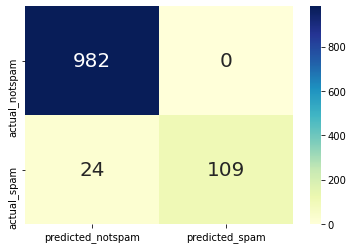

In [122]:
# The heat map for the RandomForestCLassifier model
cm_cvRF = conf_matrix(y_test, grid_rfc_predict)

In [640]:
RFcv_probability_class_1 = grid_rfc.predict_proba(X_test_cv)[:, 1]  

In [613]:
print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, probability_class_1)))

Log-loss on logit: 0.0746


In [743]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm_cvlog, cm_cvlsalog, cm_tfidflog, cm_cvknn, cm_cvBerNB, cm_cvComBerNB, cm_cvRF)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LR', 'LR_LSA', 'LR_tf', 'kNN', 'BNB', 'CNB', 'RF' ]
results

LR  LR_LSA  LR_tf    kNN    BNB    CNB     RF
Accuracy   0.983   0.909  0.987  0.955  0.992  0.974  0.978
Precision  1.000   0.657  0.984  0.988  1.000  0.861  1.000
Recall     0.857   0.489  0.902  0.632  0.932  0.932  0.820
F1 Score   0.923   0.561  0.941  0.771  0.965  0.895  0.901

In [744]:
resultdf = pd.DataFrame(results)
resultdf = resultdf.T
resultdf

Accuracy  Precision  Recall  F1 Score
LR         0.983      1.000   0.857     0.923
LR_LSA     0.909      0.657   0.489     0.561
LR_tf      0.987      0.984   0.902     0.941
kNN        0.955      0.988   0.632     0.771
BNB        0.992      1.000   0.932     0.965
CNB        0.974      0.861   0.932     0.895
RF         0.978      1.000   0.820     0.901

In [745]:
resultdf.reset_index()
resultdf

Accuracy  Precision  Recall  F1 Score
LR         0.983      1.000   0.857     0.923
LR_LSA     0.909      0.657   0.489     0.561
LR_tf      0.987      0.984   0.902     0.941
kNN        0.955      0.988   0.632     0.771
BNB        0.992      1.000   0.932     0.965
CNB        0.974      0.861   0.932     0.895
RF         0.978      1.000   0.820     0.901

In [746]:
resultdf.index

Index(['LR', 'LR_LSA', 'LR_tf', 'kNN', 'BNB', 'CNB', 'RF'], dtype='object')

In [747]:
resultdf.columns

Index(['Accuracy', 'Precision', 'Recall', 'F1 Score'], dtype='object')

In [748]:
resultdf.loc[:,'Model'] = resultdf.index
print (resultdf)

        Accuracy  Precision  Recall  F1 Score   Model
LR         0.983      1.000   0.857     0.923      LR
LR_LSA     0.909      0.657   0.489     0.561  LR_LSA
LR_tf      0.987      0.984   0.902     0.941   LR_tf
kNN        0.955      0.988   0.632     0.771     kNN
BNB        0.992      1.000   0.932     0.965     BNB
CNB        0.974      0.861   0.932     0.895     CNB
RF         0.978      1.000   0.820     0.901      RF


In [749]:
resultdf.loc["RF_CV-"] = [0.978,0.991,0.827,0.902, "RF-"]
resultdf

Accuracy  Precision  Recall  F1 Score   Model
LR         0.983      1.000   0.857     0.923      LR
LR_LSA     0.909      0.657   0.489     0.561  LR_LSA
LR_tf      0.987      0.984   0.902     0.941   LR_tf
kNN        0.955      0.988   0.632     0.771     kNN
BNB        0.992      1.000   0.932     0.965     BNB
CNB        0.974      0.861   0.932     0.895     CNB
RF         0.978      1.000   0.820     0.901      RF
RF_CV-     0.978      0.991   0.827     0.902     RF-

In [750]:
resultdf.loc["LR_LDA"] = [0.95, 0.86, 0.68, 0.76, "LR_LDA"]

resultdf

Accuracy  Precision  Recall  F1 Score   Model
LR         0.983      1.000   0.857     0.923      LR
LR_LSA     0.909      0.657   0.489     0.561  LR_LSA
LR_tf      0.987      0.984   0.902     0.941   LR_tf
kNN        0.955      0.988   0.632     0.771     kNN
BNB        0.992      1.000   0.932     0.965     BNB
CNB        0.974      0.861   0.932     0.895     CNB
RF         0.978      1.000   0.820     0.901      RF
RF_CV-     0.978      0.991   0.827     0.902     RF-
LR_LDA     0.950      0.860   0.680     0.760  LR_LDA

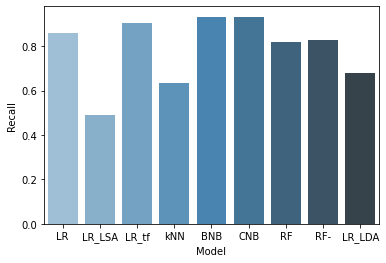

In [753]:
ax = sns.barplot(x="Model", y="Recall", data=resultdf, palette="Blues_d")

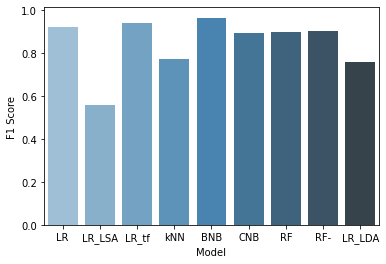

In [754]:
ax = sns.barplot(x="Model", y="F1 Score", data=resultdf, palette="Blues_d")

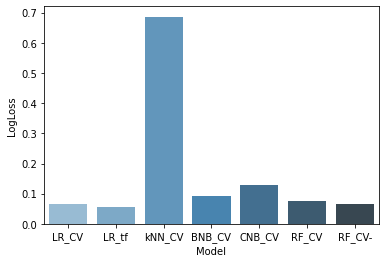

In [755]:
LogLossDF = pd.DataFrame({ 'Model' : ['LR_CV', 'LR_tf', 'kNN_CV', 'BNB_CV', 'CNB_CV', 'RF_CV', 'RF_CV-'], 'LogLoss' : [0.0670, 0.0556, 0.6861, 0.0928, 0.1295, 0.0746, 0.0670]})
         
ax = sns.barplot(x= 'Model', y= 'LogLoss', data=LogLossDF, palette="Blues_d")   

In [756]:
LogLossDF.T

0       1       2       3       4       5       6
Model    LR_CV   LR_tf  kNN_CV  BNB_CV  CNB_CV   RF_CV  RF_CV-
LogLoss  0.067  0.0556  0.6861  0.0928  0.1295  0.0746   0.067

LRcv: ROC AUC=0.989
LRtfidf: ROC AUC=0.990
KNNcv: ROC AUC=0.828
BerNBcv: ROC AUC=0.988
ComNBcv: ROC AUC=0.980
RFcv: ROC AUC=0.994


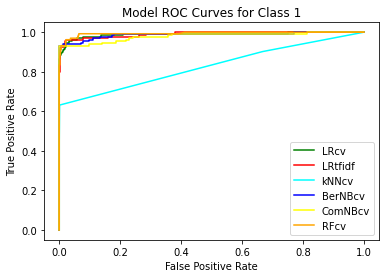

In [642]:
# generate a no skill prediction (majority class)
#ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
#ns_auc = roc_auc_score(y_test, ns_probs)
LRcv_roc_auc = roc_auc_score(y_test, LRcv_probability_class_1)
LRtfidf_roc_auc = roc_auc_score(y_test, LRtfidf_probability_class_1)
KNNcv_roc_auc = roc_auc_score(y_test, KNNcv_probability_class_1)
BerNBcv_roc_auc = roc_auc_score(y_test, BerNBcv_probability_class_1)
ComNBcv_roc_auc = roc_auc_score(y_test, ComNBcv_probability_class_1)
RFcv_roc_auc = roc_auc_score(y_test, RFcv_probability_class_1)


# summarize scores
#print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LRcv: ROC AUC=%.3f' % (LRcv_roc_auc))
print('LRtfidf: ROC AUC=%.3f' % (LRtfidf_roc_auc))
print('KNNcv: ROC AUC=%.3f' % (KNNcv_roc_auc))
print('BerNBcv: ROC AUC=%.3f' % (BerNBcv_roc_auc))
print('ComNBcv: ROC AUC=%.3f' % (ComNBcv_roc_auc))
print('RFcv: ROC AUC=%.3f' % (RFcv_roc_auc))

# calculate roc curves
#ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lrcv_fpr, lrcv_tpr, _ = roc_curve(y_test, LRcv_probability_class_1)
lrtfidf_fpr, lrtfidf_tpr, _ = roc_curve(y_test, LRtfidf_probability_class_1)
knncv_fpr, knncv_tpr, _ = roc_curve(y_test, KNNcv_probability_class_1)
bernbcv_fpr, bernbcv_tpr, _ = roc_curve(y_test, BerNBcv_probability_class_1)
comnbcv_fpr, comnbcv_tpr, _ = roc_curve(y_test, ComNBcv_probability_class_1)
rfcv_fpr, rfcv_tpr, _ = roc_curve(y_test, RFcv_probability_class_1)

# plot the roc curve for the model
#pyplot.plot(ns_fpr, ns_tpr, color='yellow', label='No Skill')
pyplot.plot(lrcv_fpr, lrcv_tpr, color='green', label='LRcv')
pyplot.plot(lrtfidf_fpr, lrtfidf_tpr, color='red', label='LRtfidf')
pyplot.plot(knncv_fpr, knncv_tpr, color='cyan', label='kNNcv')
pyplot.plot(bernbcv_fpr, bernbcv_tpr, color='blue', label='BerNBcv')
pyplot.plot(comnbcv_fpr, comnbcv_tpr, color='yellow', label='ComNBcv')
pyplot.plot(rfcv_fpr, rfcv_tpr, color='orange', label='RFcv')
pyplot.title('Model ROC Curves for Class 1');


# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


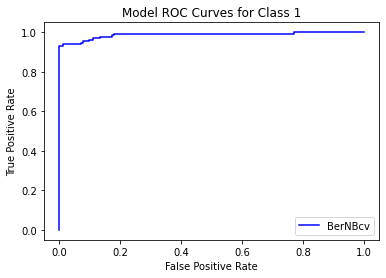

In [651]:
#pyplot.plot(rfcv_fpr, rfcv_tpr, color='orange', label='RFcv')
pyplot.plot(bernbcv_fpr, bernbcv_tpr, color='blue', label='BerNBcv')
pyplot.title('Model ROC Curves for Class 1');


# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


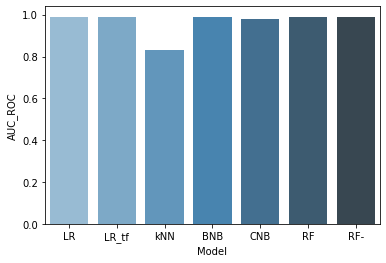

In [759]:
AUC_ROC_DF = pd.DataFrame({ 
    'Model' : ['LR', 'LR_tf', 'kNN', 'BNB', 'CNB', 'RF', 'RF-'], 'AUC_ROC' : [0.99,0.99,0.83,0.99,0.98,0.99,0.99]})

ax = sns.barplot(x= 'Model', y= 'AUC_ROC', data=AUC_ROC_DF, palette="Blues_d")   

In [758]:
AUC_ROC_DF.T

0      1     2     3     4     5     6
Model      LR  LR_tf   kNN   BNB   CNB    RF   RF-
AUC_ROC  0.99   0.99  0.83  0.99  0.98  0.99  0.99

In [719]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
from time import time

#n_samples = 2000
#n_features = 1000
n_components = 2
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


#fit data based on NMF and LDA

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, ")
#      "n_samples=%d and n_features=%d..."
#      % (n_samples, n_features))
#t0 = time()
      
nmf1 = NMF(n_components=n_components, random_state=1,alpha=.1, l1_ratio=.5)
N1 = nmf1.fit_transform(X_train_tfidf)
C1 = nmf1.components_
      
#print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf.get_feature_names()
print_top_words(nmf1, tfidf_feature_names, n_top_words)

# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d...")
#      % (n_samples, n_features))
#t0 = time()
nmf2 = NMF(n_components=n_components, random_state=1,beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,l1_ratio=.5)
N2 = nmf2.fit_transform(X_train_tfidf)
C2 = nmf2.components_
      
#print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf.get_feature_names()
print_top_words(nmf2, tfidf_feature_names, n_top_words)

print("Fitting LDA models with cv features, ")
#      "n_samples=%d and n_features=%d..."
#      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,learning_method='online',learning_offset=50.,random_state=1)
#t0 = time()
X_train_cv_lda = lda.fit_transform(X_train_cv)
#print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
cv_feature_names = cv.get_feature_names()
print_top_words(lda, cv_feature_names, n_top_words)

print("Fitting LDA models with tfidf features, ")
#      "n_samples=%d and n_features=%d..."
#      % (n_samples, n_features))
lda2 = LatentDirichletAllocation(n_components=n_components, max_iter=5,learning_method='online',learning_offset=50.,random_state=1)
#t0 = time()
X_train_tfidf_lda = lda2.fit_transform(X_train_tfidf)
#print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tfidf_feature_names = tfidf.get_feature_names()
print_top_words(lda2, tfidf_feature_names, n_top_words)

Fitting the NMF model (Frobenius norm) with tf-idf features, 

Topics in NMF model (Frobenius norm):
Topic #0: call later sorry meeting free please prize claim urgent mobile guaranteed sir customer waiting contact message line new service cash
Topic #1: ok lor thanx come go home prob oh ask wan ill leave msg take coming tell ya need like enjoy

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=%d and n_features=%d...

Topics in NMF model (generalized Kullback-Leibler divergence):
Topic #0: call gt lt get sorry free later nt send da know text good love dear please new txt pls see
Topic #1: ok come lor home go like oh going got need time take anything already lol still way yeah ask wan

Fitting LDA models with cv features, 

Topics in LDA model:
Topic #0: nt ok like got go come good get know time love day going home sorry lor still see want da
Topic #1: call gt lt free txt text get mobile stop reply new claim send please number prize week mes

In [715]:
print(C1)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.01140846 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [720]:
# Create a logistic regression model to use

LR_cv_LDA = linear_model.LogisticRegression(max_iter = 1000)
LR_tfidf_LDA = linear_model.LogisticRegression(max_iter = 1000)


# Create regularization penalty space
penalty = ['l1', 'l2']
solver = ['liblinear','lbfgs']
# Create regularization hyperparameter space
C_log = np.logspace(0, 10, 100)

# Create hyperparameter options
hyperparameters_log = dict(C=C_log, penalty=penalty, solver = solver)



In [722]:
#Use LDA-tfidf on modeling

# Train the logistic regression model using tfidf vectors
# Create grid search using 10-fold cross validation
gridLRtfidf_LDA = GridSearchCV(LR_tfidf_LDA, hyperparameters_log, cv=10, verbose=1 )

# Fit grid search
gridLRtfidf_LDA.fit(X_train_tfidf_lda, y_train)

Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': array([1.00000000e+00, 1.26185688e+00, 1.59228279e+00, 2.00923300e+00,
       2.53536449e+00, 3.19926714e+00, 4.03701726e+00, 5.09413801e+00,
       6.42807312e+00, 8.11130831e+00, 1.02353102e+01, 1.29154967e+01,
       1.62975083e+01, 2.05651231e+01, 2.59502421e+01, 3.27454916e+01,
       4.13201240e+01, 5.2140082...
       1.20450354e+08, 1.51991108e+08, 1.91791026e+08, 2.42012826e+08,
       3.05385551e+08, 3.85352859e+08, 4.86260158e+08, 6.13590727e+08,
       7.74263683e+08, 9.77009957e+08, 1.23284674e+09, 1.55567614e+09,
       1.96304065e+09, 2.47707636e+09, 3.12571585e+09, 3.94420606e+09,
       4.97702356e+09, 6.28029144e+09, 7.92482898e+09, 1.00000000e+10]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs']},
             verbose=1)

In [723]:
gridLRtfidf_LDA.best_params_

{'C': 8.11130830789687, 'penalty': 'l1', 'solver': 'liblinear'}

In [726]:
X_test_tfidf_lda = lda2.transform(X_test_tfidf)

In [727]:
gridLRtfidfLDA_predict = gridLRtfidf_LDA.predict(X_test_tfidf_lda)
print(classification_report(y_test, gridLRtfidfLDA_predict))
print(confusion_matrix(y_test, gridLRtfidfLDA_predict))
roc_auc_score(y_test, gridLRtfidfLDA_predict)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       982
           1       1.00      0.08      0.14       133

    accuracy                           0.89      1115
   macro avg       0.94      0.54      0.54      1115
weighted avg       0.90      0.89      0.85      1115

[[982   0]
 [123  10]]


0.5375939849624061

In [ ]:
#Use LDA-cv on modeling

In [728]:
# Train the logistic regression model using tfidf vectors
# Create grid search using 10-fold cross validation
gridLRcv_LDA = GridSearchCV(LR_cv_LDA, hyperparameters_log, cv=10, verbose=1 )

# Fit grid search
gridLRcv_LDA.fit(X_train_cv_lda, y_train)

Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\LSY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\LSY\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Esti

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:   27.8s finished


GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': array([1.00000000e+00, 1.26185688e+00, 1.59228279e+00, 2.00923300e+00,
       2.53536449e+00, 3.19926714e+00, 4.03701726e+00, 5.09413801e+00,
       6.42807312e+00, 8.11130831e+00, 1.02353102e+01, 1.29154967e+01,
       1.62975083e+01, 2.05651231e+01, 2.59502421e+01, 3.27454916e+01,
       4.13201240e+01, 5.2140082...
       1.20450354e+08, 1.51991108e+08, 1.91791026e+08, 2.42012826e+08,
       3.05385551e+08, 3.85352859e+08, 4.86260158e+08, 6.13590727e+08,
       7.74263683e+08, 9.77009957e+08, 1.23284674e+09, 1.55567614e+09,
       1.96304065e+09, 2.47707636e+09, 3.12571585e+09, 3.94420606e+09,
       4.97702356e+09, 6.28029144e+09, 7.92482898e+09, 1.00000000e+10]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs']},
             verbose=1)

In [729]:
gridLRcv_LDA.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}

In [730]:
X_test_cv_lda = lda.transform(X_test_cv)

In [731]:
gridLRcvLDA_predict = gridLRcv_LDA.predict(X_test_cv_lda)
print(classification_report(y_test, gridLRcvLDA_predict))
print(confusion_matrix(y_test, gridLRcvLDA_predict))
roc_auc_score(y_test, gridLRcvLDA_predict)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       982
           1       0.86      0.68      0.76       133

    accuracy                           0.95      1115
   macro avg       0.91      0.83      0.86      1115
weighted avg       0.95      0.95      0.95      1115

[[967  15]
 [ 43  90]]


0.8307083901199026